In [6]:
import os

# Get the current working directory
cwd = os.getcwd()

print(f"My current working directory is: {cwd}")

My current working directory is: d:\pyproject\github\ML_based-Pro-LTE-Opt\notebook


In [7]:
import pandas as pd
import numpy as np
import re
import os

# --- 1. Define Directories and File Paths ---

# Relative path from the 'notebook' directory to the 'Data' directory
data_dir = '../Data'

# Dictionary of files to process, with paths constructed using the relative path
files_to_process = {
    # Sector-level files
    'df_sector_nbr': {'path': os.path.join(data_dir, 'Sectors_with_Target_NBR_Cells.csv'), 'id_col': 'Source', 'type': 'sector'},
    
    # Cell-level files
    'df_cell_kpi': {'path': os.path.join(data_dir, 'cell_kpi_average_bh.csv'), 'id_col': 'element', 'type': 'cell'},
    'df_cell_config': {'path': os.path.join(data_dir, 'CEll Configuration-ardebil.csv'), 'id_col': 'Cell Name', 'type': 'cell'},
    'df_pdsch': {'path': os.path.join(data_dir, 'PDSCH Pwer config Cell_2025_05_25-ardebil.csv'), 'id_col': 'Cell Name', 'type': 'cell'},
    'df_static_params': {'path': os.path.join(data_dir, 'LST CELL+Display static parameters of cells-ardebil-.csv'), 'id_col': 'Cell Name', 'type': 'cell'},
    'df_interfreq_ncell': {'path': os.path.join(data_dir, 'EUTRANINTERFREQNCELL.csv'), 'id_col': 'cell__name', 'type': 'cell'},
    'df_intra_freq_ncell': {'path': os.path.join(data_dir, 'MoReport_EutranIntraFreqNCell-ardebil-wr.csv'), 'id_col': 'Cell Name', 'type': 'cell'},
}


# --- 2. Standardization Functions ---

def standardize_sector_id(sector_id_series):
    """Standardizes sector IDs to a common format (e.g., LH..., LT...)."""
    if not isinstance(sector_id_series, pd.Series):
        sector_id_series = pd.Series(sector_id_series)
    temp_series = sector_id_series.astype(str)
    standardized_ids = []
    for sid in temp_series:
        if pd.isna(sid) or sid.lower() == 'nan':
            standardized_ids.append(np.nan)
            continue
        sid_str = sid.strip().upper()
        if re.match(r"^[HLT][A-Z0-9]{3,}[A-Z]$", sid_str):
            if sid_str.startswith('H') and not sid_str.startswith('LH'):
                standardized_ids.append('L' + sid_str)
            elif sid_str.startswith('T') and not sid_str.startswith('LT'):
                standardized_ids.append('L' + sid_str)
            else:
                standardized_ids.append(sid_str)
        else:
            standardized_ids.append(sid_str)
    return pd.Series(standardized_ids, index=sector_id_series.index)

def derive_sector_from_cell(cell_id_series):
    """Derives a sector ID from a cell ID (e.g., LT4311XA1 -> LT4311XA)."""
    if not isinstance(cell_id_series, pd.Series):
        cell_id_series = pd.Series(cell_id_series)
    temp_series = cell_id_series.astype(str)
    derived_sectors = []
    for cid in temp_series:
        if pd.isna(cid) or cid.lower() == 'nan':
            derived_sectors.append(np.nan)
            continue
        cid_str = cid.strip().upper()
        match = re.match(r"([A-Z0-9]+[A-Z])\d+$", cid_str)
        if match:
            derived_sectors.append(match.group(1))
        else:
            if re.match(r"^[LT][A-Z0-9]{3,}[A-Z]$", cid_str):
                 derived_sectors.append(cid_str)
            else:
                derived_sectors.append(cid_str)
    return pd.Series(derived_sectors, index=cell_id_series.index)


# --- 3. Main Processing Loop ---

dataframes = {}
print("--- Starting Data Loading and Standardization ---")
for df_name, info in files_to_process.items():
    try:
        print(f"\nProcessing: {info['path']}...")
        df = pd.read_csv(info['path'], low_memory=False)
        
        # --- Apply Standardization based on file type ---
        if info['type'] == 'sector':
            df['Canonical_Sector_ID'] = standardize_sector_id(df[info['id_col']])
            print(f"Created 'Canonical_Sector_ID' from '{info['id_col']}'.")
        
        elif info['type'] == 'cell':
            # Standardize source cell ID
            df['Canonical_Cell_ID'] = df[info['id_col']].astype(str).str.strip().str.upper()
            df['Canonical_Sector_ID'] = derive_sector_from_cell(df['Canonical_Cell_ID'])
            print(f"Created 'Canonical_Cell_ID' from '{info['id_col']}' and derived 'Canonical_Sector_ID'.")

            # Standardize neighbor cell ID if it exists in the file
            if 'NeighbourCellName' in df.columns:
                 df['Canonical_Nbr_Cell_ID'] = df['NeighbourCellName'].astype(str).str.strip().str.upper()
                 print("Created 'Canonical_Nbr_Cell_ID' from 'NeighbourCellName'.")
            # Check for other possible neighbor cell column names
            # (e.g., 'nbr Cell' - you'll need to confirm the exact name from EUTRANINTERFREQNCELL.csv)
            elif 'nbr Cell' in df.columns: 
                 df['Canonical_Nbr_Cell_ID'] = df['nbr Cell'].astype(str).str.strip().str.upper()
                 print("Created 'Canonical_Nbr_Cell_ID' from 'nbr Cell'.")

        # --- Save standardized file for next steps ---
        # Get the original filename to create the new standardized filename
        original_filename = os.path.basename(info['path'])
        output_filename = os.path.join(data_dir, f"std_{original_filename}")
        
        df.to_csv(output_filename, index=False)
        print(f"Saved standardized file to: {output_filename}")
        
        dataframes[df_name] = df # Store the processed DataFrame in memory for potential immediate use
        
    except FileNotFoundError:
        print(f"ERROR: File not found -> {info['path']}. Please ensure it exists in your 'Data' directory.")
    except KeyError as e:
        print(f"ERROR: A specified column was not found in {info['path']}. Please check the 'id_col' setting. Details: {e}")
    except Exception as e:
        print(f"An error occurred while processing {info['path']}: {e}")

print("\n--- Step 1: Data Loading and Standardization Complete ---")
print("Standardized versions of your files have been saved with a 'std_' prefix in your 'Data' directory.")
print("The data is now ready for the next step: Building the Graph Components.")

--- Starting Data Loading and Standardization ---

Processing: ../Data\Sectors_with_Target_NBR_Cells.csv...
Created 'Canonical_Sector_ID' from 'Source'.
Saved standardized file to: ../Data\std_Sectors_with_Target_NBR_Cells.csv

Processing: ../Data\cell_kpi_average_bh.csv...
Created 'Canonical_Cell_ID' from 'element' and derived 'Canonical_Sector_ID'.
Saved standardized file to: ../Data\std_cell_kpi_average_bh.csv

Processing: ../Data\CEll Configuration-ardebil.csv...
Created 'Canonical_Cell_ID' from 'Cell Name' and derived 'Canonical_Sector_ID'.
Saved standardized file to: ../Data\std_CEll Configuration-ardebil.csv

Processing: ../Data\PDSCH Pwer config Cell_2025_05_25-ardebil.csv...
Created 'Canonical_Cell_ID' from 'Cell Name' and derived 'Canonical_Sector_ID'.
Saved standardized file to: ../Data\std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv

Processing: ../Data\LST CELL+Display static parameters of cells-ardebil-.csv...
Created 'Canonical_Cell_ID' from 'Cell Name' and derived 'Ca

In [8]:
import pandas as pd
import numpy as np
import os

# --- 1. Define File Paths ---
# Relative path to the data directory where standardized files are saved
data_dir = '../Data'

# Dictionary of standardized file paths
std_files = {
    'df_sector_nbr': os.path.join(data_dir, 'std_Sectors_with_Target_NBR_Cells.csv'),
    'df_cell_kpi': os.path.join(data_dir, 'std_cell_kpi_average_bh.csv'),
    'df_cell_config': os.path.join(data_dir, 'std_CEll Configuration-ardebil.csv'),
    'df_pdsch': os.path.join(data_dir, 'std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv'),
    'df_static_params': os.path.join(data_dir, 'std_LST CELL+Display static parameters of cells-ardebil-.csv'),
    'df_interfreq_ncell': os.path.join(data_dir, 'std_EUTRANINTERFREQNCELL.csv'),
    'df_intra_freq_ncell': os.path.join(data_dir, 'std_MoReport_EutranIntraFreqNCell-ardebil-wr.csv')
}

# --- Load all necessary standardized dataframes ---
dataframes = {}
print("--- Loading Standardized Data Files ---")
for name, path in std_files.items():
    try:
        dataframes[name] = pd.read_csv(path, low_memory=False)
        print(f"Successfully loaded {path}")
    except FileNotFoundError:
        print(f"ERROR: Standardized file not found -> {path}. Please ensure Step 1 ran successfully.")
        dataframes[name] = pd.DataFrame()
    except Exception as e:
        print(f"An error occurred loading {path}: {e}")
        dataframes[name] = pd.DataFrame()

# --- 2. Assemble Cell Node Features ---
print("\n--- Part 2a: Assembling Cell Node Features ---")
# Start with the KPI data as the base for our cell nodes
if not dataframes['df_cell_kpi'].empty:
    df_cell_nodes = dataframes['df_cell_kpi'].copy()

    # Define features to merge from config files
    # Note: Many column names are long and have special characters. Ensure they are correct.
    # It's good practice to clean column names, but for now we use them as is.
    
    # Features from CEll Configuration-ardebil.csv
    cell_config_features = ['Canonical_Cell_ID', 'QOFFSETFREQ', 'PREAMBLEFMT', 'Cell radius', 'TXRXMODE', 'CRSPORTNUM', 
                            'Downlink EARFCN', 'Cell ID', 'PCI', 'Cell active state', 'Root sequence index', 'PB', 
                            'QRXLEVMIN', 'QQUALMIN', 'TRESELEUTRAN', 'CELLRESELPRIORITY', 'QHYST', 'SNONINTRASEARCH', 
                            'SINTRASEARCH', 'SNONINTRASEARCHQ', 'SINTRASEARCHQ', 'INTERFREQMLBTHD', 'LOADOFFSET', 
                            'LOADDIFFTHD', 'LOADTRANSFERFACTOR']

    # Features from PDSCH Pwer config...
    pdsch_features = ['Canonical_Cell_ID', 'Reference signal power(0.1dBm)', 'PA for even power distribution(dB)', 
                      'Hysteresis value for ranking criteria(dB)', 'Threshold for non-intra frequency measurements(2dB)',
                      'Minimum required quality level(dB)', 'Inter-Frequency Mobility Load Balancing Threshold(%)', 
                      'Load Offset(%)', 'Load Difference Threshold(%)', 'Load Transfer Factor(%)', 'Mobility Load Balancing Trigger Mode', 
                      'Inter-frequency  Mobility Load Balancing UE Number Threshold', 'Inter-Frequency Idle Load Balancing Mode', 
                      'Inter-Freq Idle MLB UE Number Threshold', 'Load Balancing Frequency Select Strategy', 'Idle UE Select Frequency Scope', 
                      'Inter-Freq Offload Offset(%)', 'Inter-Freq UE Number Offload Offset', 'Cell Capacity Scale Factor', 
                      'Inter-Freq MLB Strategy', 'MLB Idle UE Number Adjust Factor', 'Idle MLB UE Number Difference Threshold(%)', 
                      'Inter-Freq Idle UE Number Offload Offset', 'Cell Synthetical Rate Handover Hysteresis(%)', 
                      'Cell Traffic Load Threshold(ms)', 'Inter-Freq Measurement Load Ratio Threshold(%)', 
                      'Inter-Freq Measurement MCS Threshold', 'Inter-Freq Measurement Service Threshold(byte)', 
                      'Measurement Information Update Interval', 'UE Spectral Efficiency Handover Hysteresis(%)', 
                      'Load Difference Ratio Threshold(%)', 'Interfreq handover group ID', 'Interfreq A1A2 hysteresis(0.5dB)', 
                      'Interfreq A3 offset(0.5dB)']

    # Features from LST CELL+Display static parameters...
    static_params_features = ['Canonical_Cell_ID', 'Downlink bandwidth', 'Frequency offset(dB)']
    
    # Function to safely merge, avoiding duplicate columns other than the key
    def safe_merge(left_df, right_df_name, columns_to_merge):
        if right_df_name in dataframes and not dataframes[right_df_name].empty:
            right_df = dataframes[right_df_name]
            # Ensure columns exist in the dataframe before trying to select them
            cols_exist = [col for col in columns_to_merge if col in right_df.columns]
            if 'Canonical_Cell_ID' in cols_exist:
                print(f"Merging features from {right_df_name}...")
                # To avoid duplicate columns from merges, select only new columns + the key
                new_cols = [col for col in cols_exist if col not in left_df.columns or col == 'Canonical_Cell_ID']
                return pd.merge(left_df, right_df[new_cols].drop_duplicates(subset=['Canonical_Cell_ID']), on='Canonical_Cell_ID', how='left')
        print(f"Skipping merge with {right_df_name} (not found or empty).")
        return left_df

    df_cell_nodes = safe_merge(df_cell_nodes, 'df_cell_config', cell_config_features)
    df_cell_nodes = safe_merge(df_cell_nodes, 'df_pdsch', pdsch_features)
    df_cell_nodes = safe_merge(df_cell_nodes, 'df_static_params', static_params_features)

    # Save the result
    output_path = os.path.join(data_dir, "graph_cell_node_features.csv")
    df_cell_nodes.to_csv(output_path, index=False)
    print(f"\nCell node features saved to {output_path}")
else:
    print("Could not create cell node features because std_cell_kpi_average_bh.csv was not loaded.")


# --- 3. Assemble Cell Edge List ---
print("\n--- Part 2b: Assembling Cell Edge List ---")
cell_edge_lists = []
# Intra-frequency edges
if not dataframes['df_intra_freq_ncell'].empty:
    df_intra = dataframes['df_intra_freq_ncell']
    # Select and rename columns to a standard format
    intra_cols = {'Canonical_Cell_ID': 'source', 'Canonical_Nbr_Cell_ID': 'target', 
                  'CellIndividualOffset': 'feat_cell_offset', 'CellQoffset': 'feat_qoffset', 'NoHoFlag': 'feat_no_ho'}
    # Filter for columns that actually exist
    intra_cols = {k: v for k, v in intra_cols.items() if k in df_intra.columns}
    if 'source' in intra_cols.values() and 'target' in intra_cols.values():
        df_intra_edges = df_intra[list(intra_cols.keys())].rename(columns=intra_cols)
        df_intra_edges['edge_type'] = 'intra_freq'
        cell_edge_lists.append(df_intra_edges)
        print(f"Processed {len(df_intra_edges)} intra-frequency cell edges.")

# Inter-frequency edges
if not dataframes['df_interfreq_ncell'].empty:
    df_inter = dataframes['df_interfreq_ncell']
    # Select and rename columns (assuming 'Canonical_Nbr_Cell_ID' was created from 'nbr Cell' or similar)
    inter_cols = {'Canonical_Cell_ID': 'source', 'Canonical_Nbr_Cell_ID': 'target', 
                  'CELLINDIVIDUALOFFSET': 'feat_cell_offset'}
    inter_cols = {k: v for k, v in inter_cols.items() if k in df_inter.columns}
    if 'source' in inter_cols.values() and 'target' in inter_cols.values():
        df_inter_edges = df_inter[list(inter_cols.keys())].rename(columns=inter_cols)
        df_inter_edges['edge_type'] = 'inter_freq'
        cell_edge_lists.append(df_inter_edges)
        print(f"Processed {len(df_inter_edges)} inter-frequency cell edges.")

if cell_edge_lists:
    df_cell_edges = pd.concat(cell_edge_lists, ignore_index=True).dropna(subset=['source', 'target'])
    output_path = os.path.join(data_dir, "graph_cell_edge_list.csv")
    df_cell_edges.to_csv(output_path, index=False)
    print(f"\nCell edge list saved to {output_path}")
else:
    print("No cell edge data could be processed.")


# --- 4. Assemble Sector Node & Edge Features ---
print("\n--- Part 3: Assembling Sector Graph Components ---")
if not dataframes['df_sector_nbr'].empty:
    df_sector_base = dataframes['df_sector_nbr']
    
    # Part 3a: Sector Node Features
    sector_node_cols = ['Canonical_Sector_ID', 'ACTIVE_UE_DL', 'MAX_BEARABLE_USERS', 'UDCLI', 
                        'PAYLOAD_PDCP_DL_GBYTE', 'RB_UTILIZATION_DL', 'THRPUT_UE_DL', 
                        'Number_of_Neighbors', 'Source Longitude', 'Source Latitude', 
                        'Source Height (m)', 'Source Azimuth', 'Source Mechanical Downtilt']
    sector_node_cols = [col for col in sector_node_cols if col in df_sector_base.columns]
    df_sector_nodes = df_sector_base[sector_node_cols].drop_duplicates(subset=['Canonical_Sector_ID'])
    output_path = os.path.join(data_dir, "graph_sector_node_features.csv")
    df_sector_nodes.to_csv(output_path, index=False)
    print(f"Sector node features saved to {output_path}")

    # Part 3b: Sector Edge List
    # This requires "melting" the wide NBR format to a long edge list format
    # We will iterate through each NBR (1 to 9)
    sector_edge_lists = []
    for i in range(1, 10):
        # Check if the required columns for this NBR exist
        target_col = f'Targets NBR{i}'
        util_col = f'Utilizations NBR{i}'
        udcli_col = f'UDCLIs NBR{i}'
        dist_col = f'Distances NBR{i}'
        # Add other NBR features if needed

        if target_col in df_sector_base.columns:
            # Create a temporary dataframe for this NBR level
            edge_df = df_sector_base[['Canonical_Sector_ID', target_col]].copy()
            edge_df.dropna(subset=[target_col], inplace=True) # Remove rows where this NBR doesn't exist
            edge_df.rename(columns={'Canonical_Sector_ID': 'source', target_col: 'target'}, inplace=True)
            
            # Add edge features
            if util_col in df_sector_base.columns: edge_df['feat_utilization'] = df_sector_base[util_col]
            if udcli_col in df_sector_base.columns: edge_df['feat_udcli'] = df_sector_base[udcli_col]
            if dist_col in df_sector_base.columns: edge_df['feat_distance'] = df_sector_base[dist_col]
            
            sector_edge_lists.append(edge_df)
    
    if sector_edge_lists:
        df_sector_edges = pd.concat(sector_edge_lists, ignore_index=True)
        # Standardize target sector names as well
        df_sector_edges['target'] = standardize_sector_id(df_sector_edges['target'])
        output_path = os.path.join(data_dir, "graph_sector_edge_list.csv")
        df_sector_edges.to_csv(output_path, index=False)
        print(f"Sector edge list saved to {output_path}")
    else:
        print("No sector edge data could be processed.")
else:
    print("Could not create sector graph components because std_Sectors_with_Target_NBR_Cells.csv was not loaded.")


# --- 5. Define the Hierarchy Map ---
print("\n--- Part 4: Defining the Hierarchy Map ---")
if 'df_cell_kpi' in dataframes and not dataframes['df_cell_kpi'].empty and \
   'Canonical_Cell_ID' in dataframes['df_cell_kpi'].columns and \
   'Canonical_Sector_ID' in dataframes['df_cell_kpi'].columns:
   
    df_hierarchy_map = dataframes['df_cell_kpi'][['Canonical_Cell_ID', 'Canonical_Sector_ID']].dropna().drop_duplicates()
    output_path = os.path.join(data_dir, "graph_hierarchy_map.csv")
    df_hierarchy_map.to_csv(output_path, index=False)
    print(f"Hierarchy map (cell-to-sector) saved to {output_path}")
else:
    print("Could not create hierarchy map.")

print("\n--- All Graph Components Have Been Assembled and Saved ---")

--- Loading Standardized Data Files ---
Successfully loaded ../Data\std_Sectors_with_Target_NBR_Cells.csv
Successfully loaded ../Data\std_cell_kpi_average_bh.csv
Successfully loaded ../Data\std_CEll Configuration-ardebil.csv
Successfully loaded ../Data\std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv
Successfully loaded ../Data\std_LST CELL+Display static parameters of cells-ardebil-.csv
Successfully loaded ../Data\std_EUTRANINTERFREQNCELL.csv
Successfully loaded ../Data\std_MoReport_EutranIntraFreqNCell-ardebil-wr.csv

--- Part 2a: Assembling Cell Node Features ---
Merging features from df_cell_config...
Merging features from df_pdsch...
Merging features from df_static_params...

Cell node features saved to ../Data\graph_cell_node_features.csv

--- Part 2b: Assembling Cell Edge List ---
Processed 131270 intra-frequency cell edges.
Processed 204629 inter-frequency cell edges.

Cell edge list saved to ../Data\graph_cell_edge_list.csv

--- Part 3: Assembling Sector Graph Components ---


In [9]:
import pandas as pd
import torch
import torch.nn.functional as F
# PyTorch Geometric is a library built upon PyTorch for graph neural networks.
# You might need to install it: pip install torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool

# --- 1. Load the Graph Component Files ---
data_dir = '../Data' # Assuming the notebook is still in the 'notebook' directory
try:
    print("--- Loading Graph Components ---")
    df_cell_nodes = pd.read_csv(os.path.join(data_dir, 'graph_cell_node_features.csv'))
    df_cell_edges = pd.read_csv(os.path.join(data_dir, 'graph_cell_edge_list.csv'))
    df_sector_nodes = pd.read_csv(os.path.join(data_dir, 'graph_sector_node_features.csv'))
    df_sector_edges = pd.read_csv(os.path.join(data_dir, 'graph_sector_edge_list.csv'))
    df_hierarchy = pd.read_csv(os.path.join(data_dir, 'graph_hierarchy_map.csv'))
    print("All graph component files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required graph component file was not found. Please ensure Step 2 ran successfully. Details: {e}")
    exit()

# --- 2. Pre-process Data for PyTorch Geometric ---
print("\n--- Pre-processing data for PyTorch Geometric ---")

# -- Cell Graph --
# Create a mapping from canonical cell ID string to a unique integer index
cell_id_map = {name: i for i, name in enumerate(df_cell_nodes['Canonical_Cell_ID'].unique())}
df_cell_nodes['node_idx'] = df_cell_nodes['Canonical_Cell_ID'].map(cell_id_map)
df_cell_edges['source_idx'] = df_cell_edges['source'].map(cell_id_map)
df_cell_edges['target_idx'] = df_cell_edges['target'].map(cell_id_map)

# Select and convert node features to a PyTorch tensor
# For now, select only numeric columns. Categorical ones need encoding first.
cell_numeric_features = df_cell_nodes.select_dtypes(include=np.number).drop(columns=['node_idx']).fillna(0)
cell_x = torch.tensor(cell_numeric_features.values, dtype=torch.float)

# Create the edge index tensor
cell_edge_index = torch.tensor(df_cell_edges[['source_idx', 'target_idx']].dropna().values, dtype=torch.long).t().contiguous()

# Create the PyG Data object for the cell graph
cell_graph = Data(x=cell_x, edge_index=cell_edge_index)
print(f"Cell Graph created: {cell_graph}")

# -- Sector Graph --
# Create a mapping from canonical sector ID string to a unique integer index
sector_id_map = {name: i for i, name in enumerate(df_sector_nodes['Canonical_Sector_ID'].unique())}
df_sector_nodes['node_idx'] = df_sector_nodes['Canonical_Sector_ID'].map(sector_id_map)
df_sector_edges['source_idx'] = df_sector_edges['source'].map(sector_id_map)
df_sector_edges['target_idx'] = df_sector_edges['target'].map(sector_id_map)

# Select and convert node features to a PyTorch tensor
sector_numeric_features = df_sector_nodes.select_dtypes(include=np.number).drop(columns=['node_idx']).fillna(0)
sector_x = torch.tensor(sector_numeric_features.values, dtype=torch.float)

# Create the edge index tensor
sector_edge_index = torch.tensor(df_sector_edges[['source_idx', 'target_idx']].dropna().values, dtype=torch.long).t().contiguous()

# Create the PyG Data object for the sector graph
sector_graph = Data(x=sector_x, edge_index=sector_edge_index)
print(f"Sector Graph created: {sector_graph}")

# -- Hierarchy Map --
# This tensor maps each cell (by its index) to its parent sector (by its index)
df_hierarchy['cell_idx'] = df_hierarchy['Canonical_Cell_ID'].map(cell_id_map)
df_hierarchy['sector_idx'] = df_hierarchy['Canonical_Sector_ID'].map(sector_id_map)
# Drop any rows where a cell or sector ID might not have been found in the maps
df_hierarchy.dropna(subset=['cell_idx', 'sector_idx'], inplace=True)
hierarchy_batch_vector = torch.tensor(df_hierarchy['sector_idx'].values, dtype=torch.long)
print(f"Hierarchy map created. Total cells mapped: {len(hierarchy_batch_vector)}")


# --- 3. Define the H-GNN Model Architecture ---
print("\n--- Part 3: Defining the Hierarchical GNN Model ---")

class HierarchicalGAT(torch.nn.Module):
    def __init__(self, cell_in_features, cell_hidden_dim, cell_out_features, 
                 sector_in_features, sector_hidden_dim, sector_out_features, 
                 num_final_classes, heads=4):
        super(HierarchicalGAT, self).__init__()
        
        # --- Cell-Level GAT (Layer 2) ---
        # Takes raw cell features and processes them using cell-to-cell graph
        self.cell_gat1 = GATConv(cell_in_features, cell_hidden_dim, heads=heads)
        self.cell_gat2 = GATConv(cell_hidden_dim * heads, cell_out_features, heads=1)

        # --- Sector-Level GAT (Layer 1) ---
        # The input features will be the original sector features PLUS the aggregated cell features
        total_sector_in_features = sector_in_features + cell_out_features
        self.sector_gat1 = GATConv(total_sector_in_features, sector_hidden_dim, heads=heads)
        self.sector_gat2 = GATConv(sector_hidden_dim * heads, sector_out_features, heads=1)

        # --- Final Classifier ---
        # A simple linear layer to make the final prediction from the sector embeddings
        self.classifier = torch.nn.Linear(sector_out_features, num_final_classes)

    def forward(self, cell_data, sector_data, hierarchy_batch):
        # Unpack the data objects
        cell_x, cell_edge_index = cell_data.x, cell_data.edge_index
        sector_x, sector_edge_index = sector_data.x, sector_data.edge_index

        # === Stage 1: Bottom-Up Processing (Cell to Sector) ===
        
        # 1. Pass through the cell-level GAT layers
        cell_x = F.dropout(cell_x, p=0.6, training=self.training)
        cell_x = F.elu(self.cell_gat1(cell_x, cell_edge_index))
        cell_x = F.dropout(cell_x, p=0.6, training=self.training)
        cell_x = self.cell_gat2(cell_x, cell_edge_index)
        # Now, `cell_x` contains a rich embedding for each cell

        # 2. Aggregate cell embeddings to get a single vector per sector
        # We use global_mean_pool with the hierarchy_batch vector. This averages all cell
        # embeddings that belong to the same sector.
        sector_aggregated_cell_features = global_mean_pool(cell_x, hierarchy_batch)

        # 3. Concatenate original sector features with aggregated cell features
        combined_sector_features = torch.cat([sector_data.x, sector_aggregated_cell_features], dim=1)

        # === Stage 2: Top-Down Processing (Sector to Sector) ===
        
        # 4. Pass the combined features through the sector-level GAT layers
        sector_x = F.dropout(combined_sector_features, p=0.6, training=self.training)
        sector_x = F.elu(self.sector_gat1(sector_x, sector_edge_index))
        sector_x = F.dropout(sector_x, p=0.6, training=self.training)
        sector_x = self.sector_gat2(sector_x, sector_edge_index)
        # Now, `sector_x` contains the final, context-aware embedding for each sector

        # 5. Make the final prediction
        # (e.g., for predicting overutilization probability)
        out = self.classifier(sector_x)
        
        return F.log_softmax(out, dim=1)


# --- 4. Instantiate the Model (Example) ---
# NOTE: These numbers are placeholders. They MUST be replaced with the actual dimensions
# from your final feature DataFrames.
NUM_CELL_FEATURES = cell_graph.num_node_features
NUM_SECTOR_FEATURES = sector_graph.num_node_features
NUM_FINAL_CLASSES = 2 # e.g., for a binary classification: Not Overutilized (0) vs. Overutilized (1)

model = HierarchicalGAT(
    cell_in_features=NUM_CELL_FEATURES,
    cell_hidden_dim=32,
    cell_out_features=64, # The size of the embedding passed from cell to sector layer
    sector_in_features=NUM_SECTOR_FEATURES,
    sector_hidden_dim=64,
    sector_out_features=32,
    num_final_classes=NUM_FINAL_CLASSES
)

print("\n--- H-GNN Model Architecture ---")
print(model)

--- Loading Graph Components ---


C:\Users\hossein.hab\AppData\Local\Temp\ipykernel_20740\3642884600.py:14: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cell_edges = pd.read_csv(os.path.join(data_dir, 'graph_cell_edge_list.csv'))


All graph component files loaded successfully.

--- Pre-processing data for PyTorch Geometric ---
Cell Graph created: Data(x=[2724, 68], edge_index=[2, 204213])
Sector Graph created: Data(x=[784, 10], edge_index=[2, 2922])
Hierarchy map created. Total cells mapped: 2637

--- Part 3: Defining the Hierarchical GNN Model ---

--- H-GNN Model Architecture ---
HierarchicalGAT(
  (cell_gat1): GATConv(68, 32, heads=4)
  (cell_gat2): GATConv(128, 64, heads=1)
  (sector_gat1): GATConv(74, 64, heads=4)
  (sector_gat2): GATConv(256, 32, heads=1)
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


--- Loading Graph Components ---
Successfully loaded ../Data\graph_cell_node_features.csv
Successfully loaded ../Data\graph_cell_edge_list.csv
Successfully loaded ../Data\graph_sector_node_features.csv
Successfully loaded ../Data\graph_sector_edge_list.csv
Successfully loaded ../Data\graph_hierarchy_map.csv

--- Part 1: Statistical Deep Check ---

--- Analysis of Sector Node Features (graph_sector_node_features.csv) ---
Description of numeric features:
       ACTIVE_UE_DL       UDCLI  PAYLOAD_PDCP_DL_GBYTE  RB_UTILIZATION_DL  \
count    784.000000  784.000000             784.000000         784.000000   
mean       9.368673    0.707472             349.074672          51.359355   
std        9.886918    0.653220             229.220482          23.416415   
min        0.056667    0.019279               1.689515           2.842500   
25%        2.872500    0.281702             150.136158          32.053333   
50%        6.683333    0.514638             330.908045          52.441250   
75% 

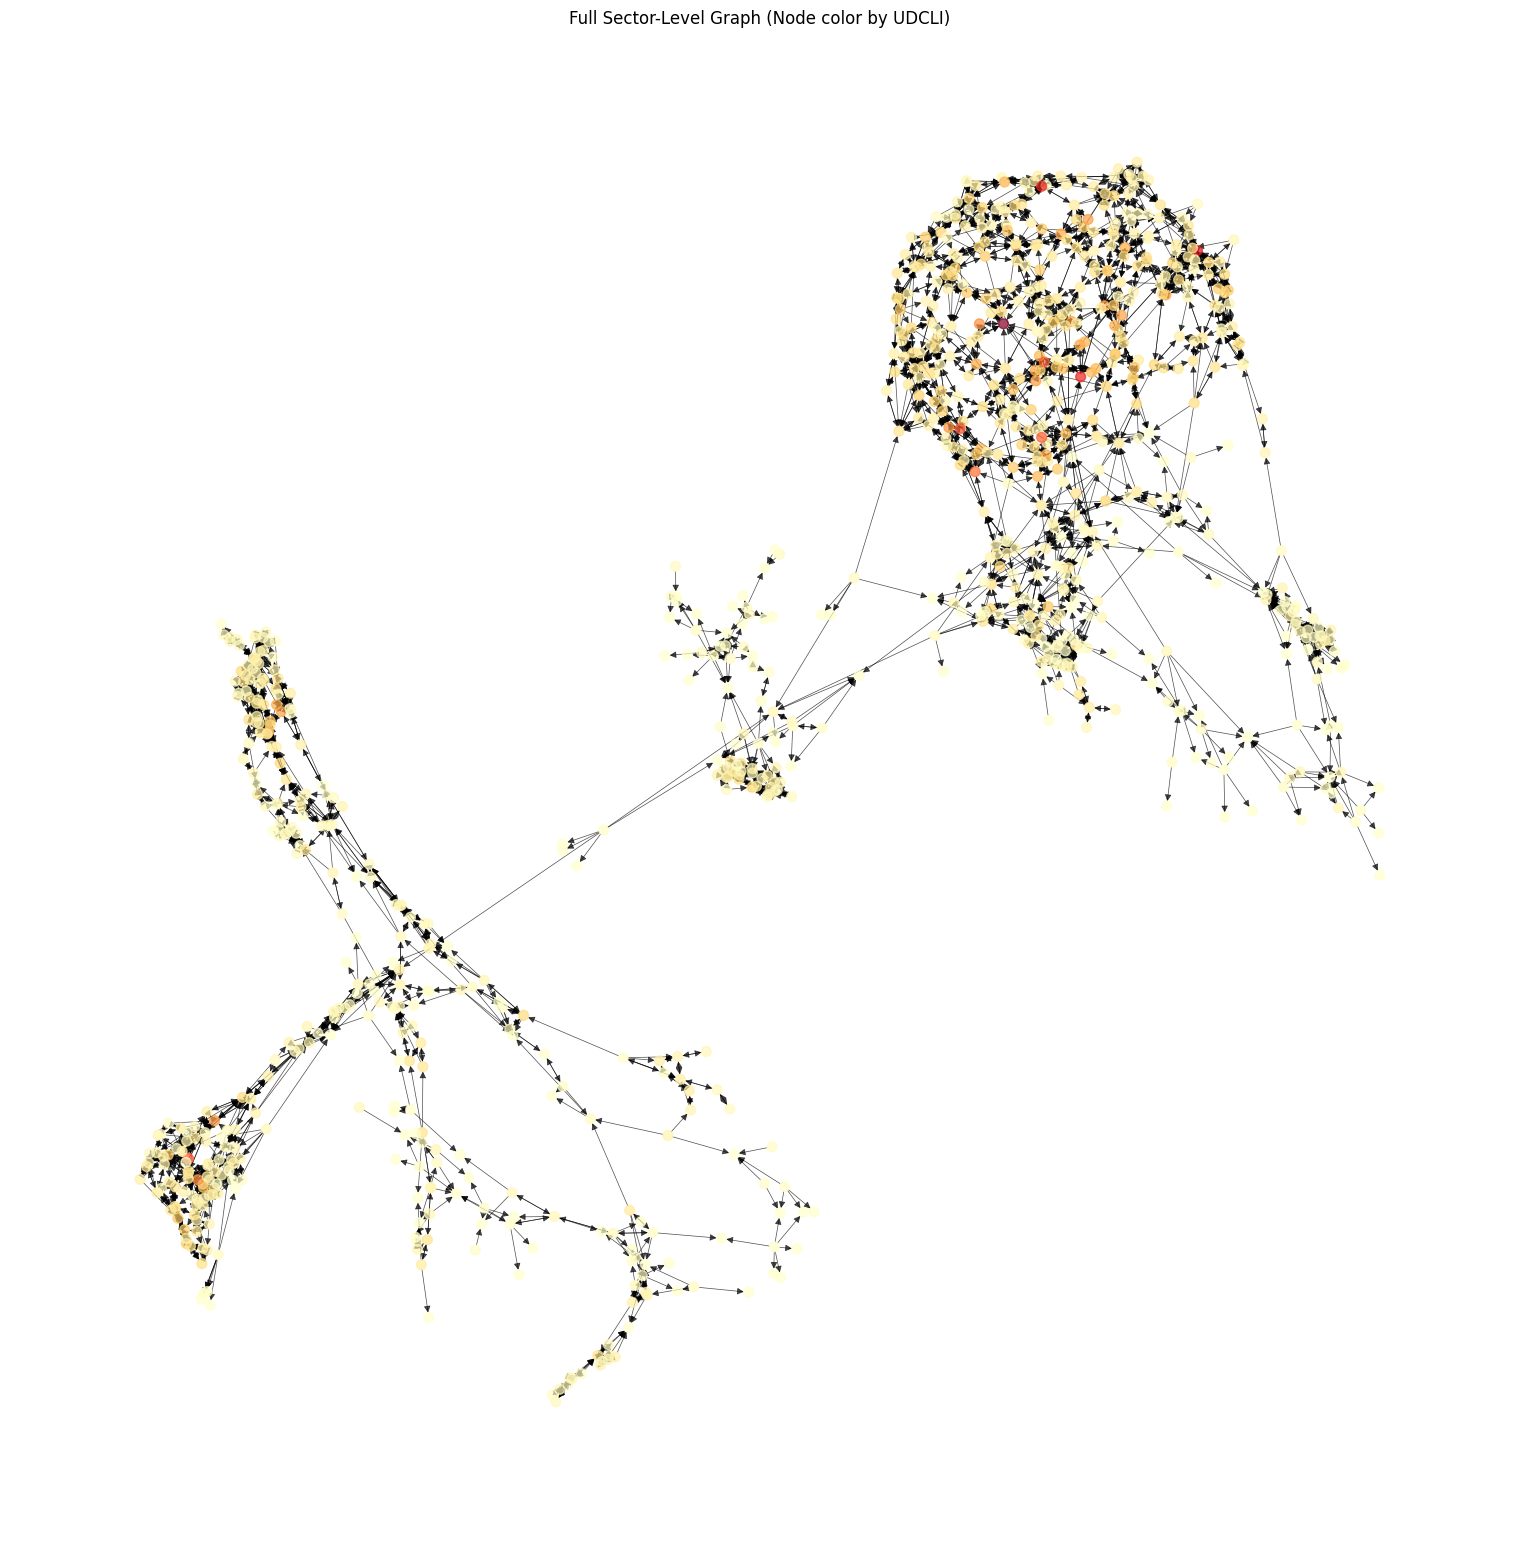


Visualizing a sample neighborhood...


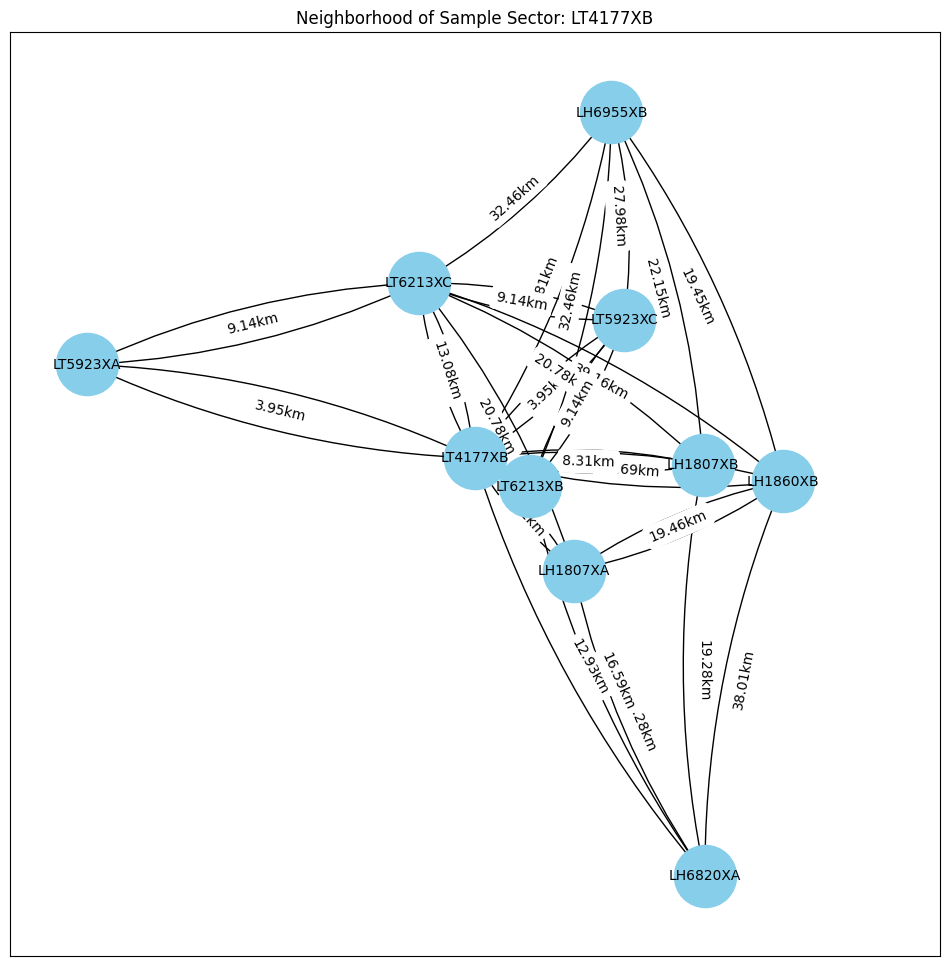

In [11]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Load the Graph Component Files ---
data_dir = '../Data'
file_paths = {
    'cell_nodes': os.path.join(data_dir, 'graph_cell_node_features.csv'),
    'cell_edges': os.path.join(data_dir, 'graph_cell_edge_list.csv'),
    'sector_nodes': os.path.join(data_dir, 'graph_sector_node_features.csv'),
    'sector_edges': os.path.join(data_dir, 'graph_sector_edge_list.csv'),
    'hierarchy': os.path.join(data_dir, 'graph_hierarchy_map.csv'),
}
dataframes = {}
print("--- Loading Graph Components ---")
for name, path in file_paths.items():
    try:
        dataframes[name] = pd.read_csv(path, low_memory=False)
        print(f"Successfully loaded {path}")
    except FileNotFoundError:
        print(f"ERROR: File not found -> {path}. Please ensure the previous step ran successfully.")
        dataframes[name] = pd.DataFrame()
    except Exception as e:
        print(f"An error occurred loading {path}: {e}")
        dataframes[name] = pd.DataFrame()

# --- 2. Statistical Deep Check of Features and Edges ---
print("\n" + "="*50)
print("--- Part 1: Statistical Deep Check ---")

# -- Sector Node Features --
if not dataframes['sector_nodes'].empty:
    print("\n--- Analysis of Sector Node Features (graph_sector_node_features.csv) ---")
    print("Description of numeric features:")
    # Select a subset of key features to describe
    key_sector_features = ['ACTIVE_UE_DL', 'UDCLI', 'PAYLOAD_PDCP_DL_GBYTE', 'RB_UTILIZATION_DL', 'THRPUT_UE_DL', 'Number_of_Neighbors']
    key_sector_features_exist = [f for f in key_sector_features if f in dataframes['sector_nodes'].columns]
    print(dataframes['sector_nodes'][key_sector_features_exist].describe())
    print("\nMissing values count:")
    print(dataframes['sector_nodes'].isnull().sum())

# -- Cell Node Features --
if not dataframes['cell_nodes'].empty:
    print("\n--- Analysis of Cell Node Features (graph_cell_node_features.csv) ---")
    print("Description of a sample of numeric features:")
    # Describe a smaller sample of features to keep output readable
    key_cell_features = [col for col in dataframes['cell_nodes'].columns if 'Avg BH' in col and 'Util' in col]
    if not key_cell_features: # Fallback if no specific kpis found
        key_cell_features = [col for col in dataframes['cell_nodes'].select_dtypes(include=np.number).columns if 'L.RA' not in col][:5]
    print(dataframes['cell_nodes'][key_cell_features].describe())
    print("\nTotal Missing values:", dataframes['cell_nodes'].isnull().sum().sum())
    
# -- Sector Edge Features --
if not dataframes['sector_edges'].empty:
    print("\n--- Analysis of Sector Edge Features (graph_sector_edge_list.csv) ---")
    print("Description of numeric edge features:")
    print(dataframes['sector_edges'].describe())
    
# -- Cell Edge Features --
if not dataframes['cell_edges'].empty:
    print("\n--- Analysis of Cell Edge Features (graph_cell_edge_list.csv) ---")
    print("Value counts for 'edge_type':")
    print(dataframes['cell_edges']['edge_type'].value_counts())
    print("\nDescription of numeric edge features:")
    print(dataframes['cell_edges'].describe())

# --- 3. Graph Visualization ---
print("\n" + "="*50)
print("--- Part 2: Graph Visualization ---")

if not dataframes['sector_edges'].empty and not dataframes['sector_nodes'].empty:
    # Create a NetworkX graph object from the sector edge list
    G_sector = nx.from_pandas_edgelist(
        dataframes['sector_edges'],
        source='source',
        target='target',
        edge_attr=True, # Include all other columns as edge attributes
        create_using=nx.DiGraph() # Use a directed graph
    )
    
    print(f"\nSector-level graph created with {G_sector.number_of_nodes()} nodes and {G_sector.number_of_edges()} edges.")

    # --- Visualization of the Whole Sector Graph ---
    print("\nVisualizing the whole sector graph (this may take a moment and appear dense)...")
    plt.figure(figsize=(15, 15))
    
    # Use node colors to represent UDCLI
    node_colors = []
    # Create a mapping from sector ID to UDCLI for coloring
    udcli_map = dataframes['sector_nodes'].set_index('Canonical_Sector_ID')['UDCLI'].to_dict()
    for node in G_sector.nodes():
        # Use a default color if node not in the map (shouldn't happen if data is consistent)
        node_colors.append(udcli_map.get(node, 0))

    pos = nx.spring_layout(G_sector, k=0.5, iterations=50) # spring_layout is good for visualizing structure
    nx.draw(G_sector, pos, 
            node_color=node_colors, 
            cmap=plt.cm.YlOrRd, 
            with_labels=False, 
            node_size=50, 
            width=0.5,
            alpha=0.7)
    plt.title("Full Sector-Level Graph (Node color by UDCLI)")
    plt.show()

    # --- Visualization of a Sample Node and its Neighborhood ---
    print("\nVisualizing a sample neighborhood...")
    
    # Find a node with a high number of neighbors to make an interesting plot
    if not dataframes['sector_nodes'].empty and 'Number_of_Neighbors' in dataframes['sector_nodes'].columns:
        sample_node_id = dataframes['sector_nodes'].nlargest(1, 'Number_of_Neighbors')['Canonical_Sector_ID'].iloc[0]
        
        # Create a list of the sample node and its direct neighbors
        neighbors = list(G_sector.predecessors(sample_node_id)) + list(G_sector.successors(sample_node_id))
        neighborhood_nodes = list(set([sample_node_id] + neighbors))
        
        # Create a subgraph of this neighborhood
        G_sample = G_sector.subgraph(neighborhood_nodes)

        plt.figure(figsize=(12, 12))
        sample_pos = nx.spring_layout(G_sample, seed=42)
        
        # Draw the nodes
        nx.draw_networkx_nodes(G_sample, sample_pos, node_size=2000, node_color='skyblue')
        
        # Draw the edges
        nx.draw_networkx_edges(G_sample, sample_pos, arrowstyle='->', arrowsize=20, connectionstyle='arc3,rad=0.1')
        
        # Draw the labels
        nx.draw_networkx_labels(G_sample, sample_pos, font_size=10)
        
        # Draw edge labels (e.g., distance)
        try:
            edge_labels = {(u, v): f"{d['feat_distance']:.2f}km" for u, v, d in G_sample.edges(data=True) if 'feat_distance' in d}
            nx.draw_networkx_edge_labels(G_sample, sample_pos, edge_labels=edge_labels)
        except Exception as e:
            print(f"Could not draw edge labels: {e}")

        plt.title(f"Neighborhood of Sample Sector: {sample_node_id}")
        plt.show()
    else:
        print("Could not select a sample node because 'Number_of_Neighbors' column is missing.")
else:
    print("\nSkipping visualization because sector graph components are missing.")

--- Loading Graph Components ---
Successfully loaded ../Data\graph_cell_node_features.csv
Successfully loaded ../Data\graph_cell_edge_list.csv
Successfully loaded ../Data\graph_sector_node_features.csv
Successfully loaded ../Data\graph_sector_edge_list.csv
Successfully loaded ../Data\graph_hierarchy_map.csv

--- Part 1: Statistical Deep Check ---

--- Analysis of Sector Node Features (graph_sector_node_features.csv) ---
Description of numeric features:
       ACTIVE_UE_DL       UDCLI  PAYLOAD_PDCP_DL_GBYTE  RB_UTILIZATION_DL  \
count    784.000000  784.000000             784.000000         784.000000   
mean       9.368673    0.707472             349.074672          51.359355   
std        9.886918    0.653220             229.220482          23.416415   
min        0.056667    0.019279               1.689515           2.842500   
25%        2.872500    0.281702             150.136158          32.053333   
50%        6.683333    0.514638             330.908045          52.441250   
75% 

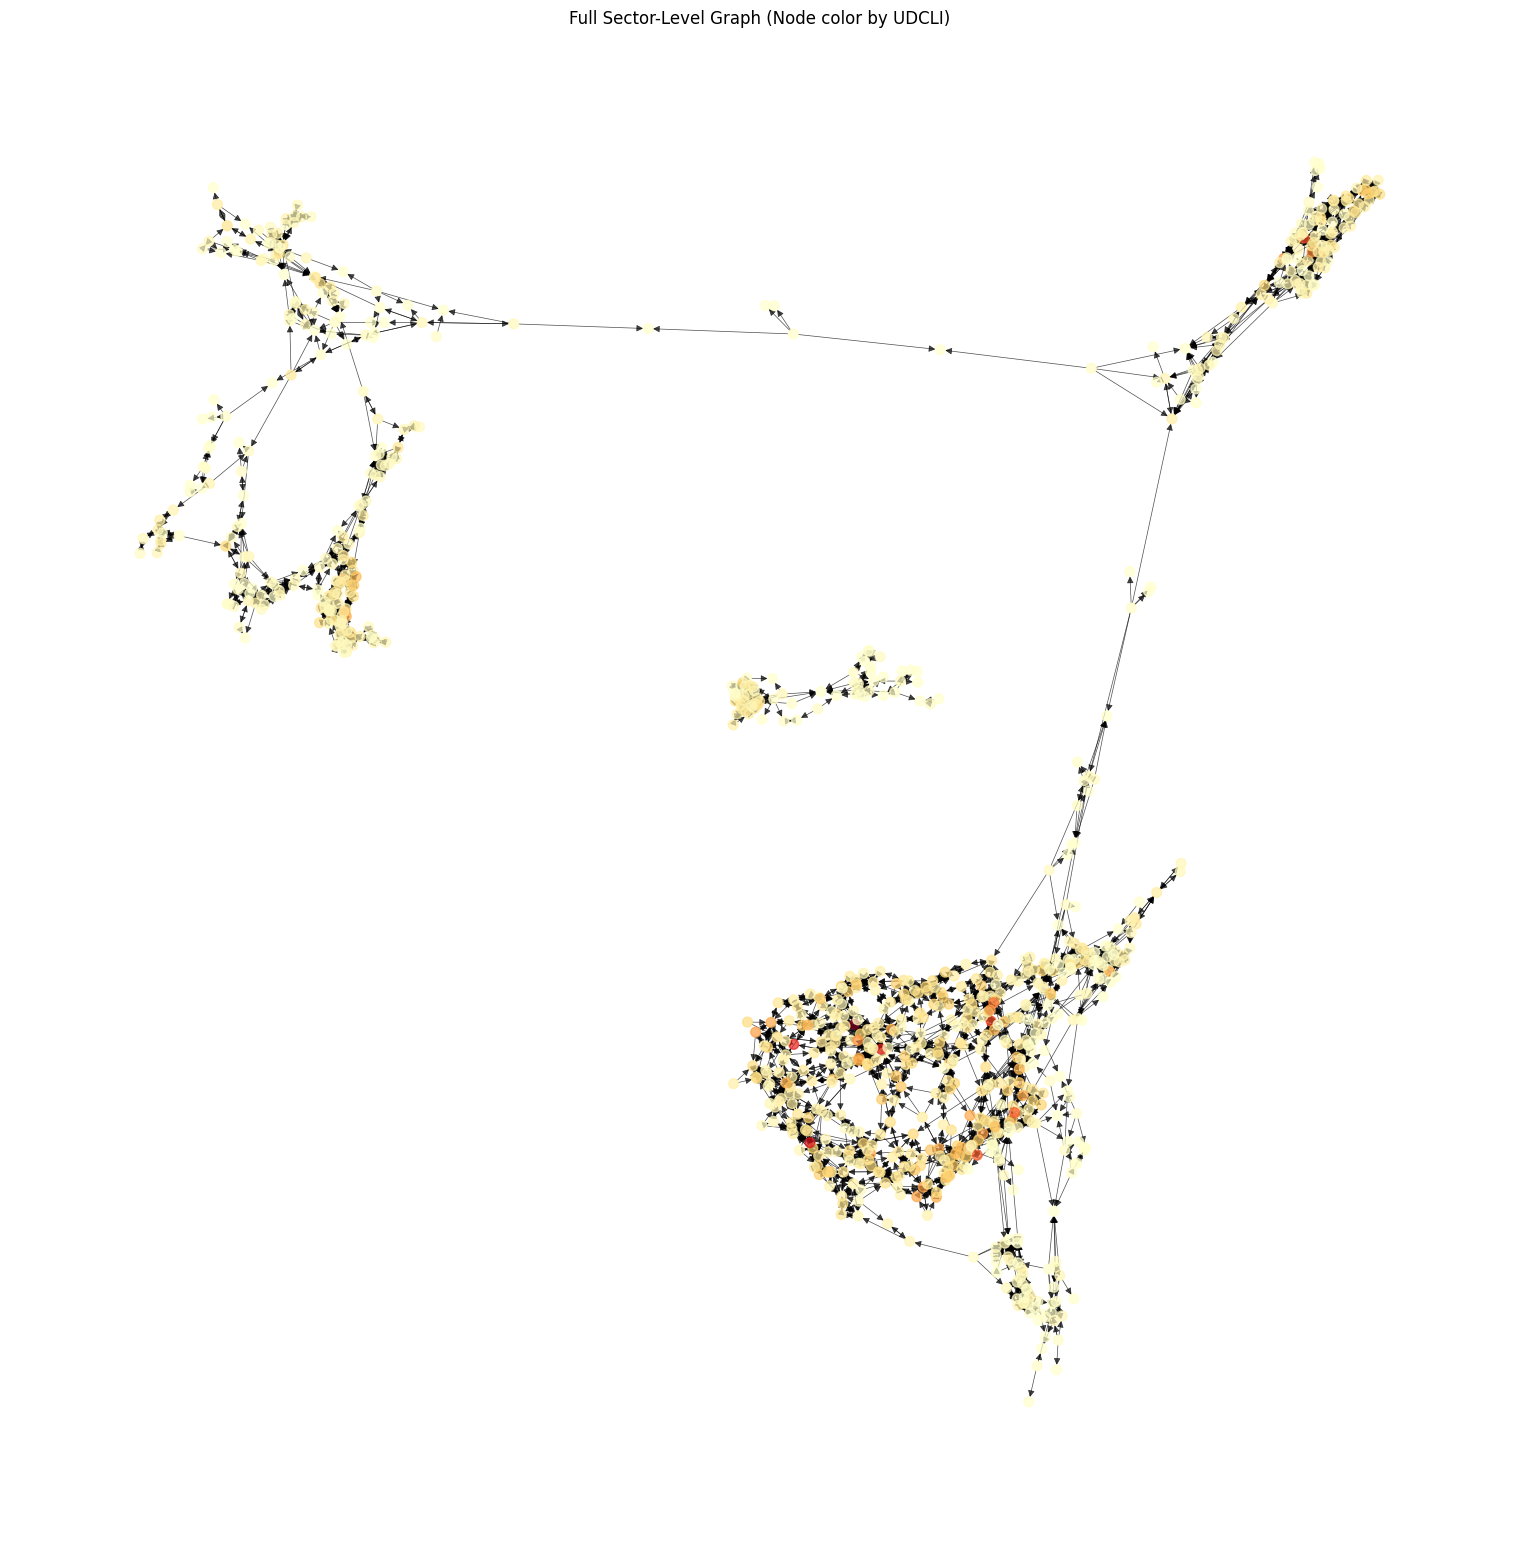


Visualizing a sample neighborhood...


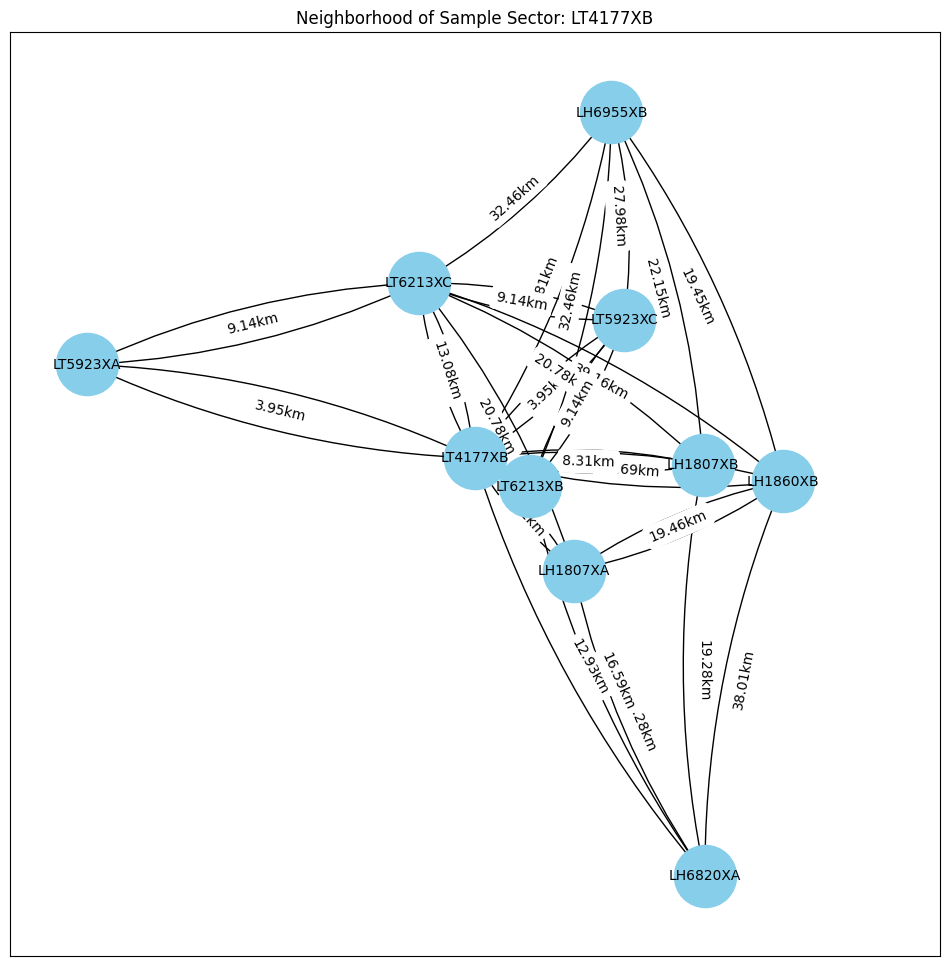

In [12]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Load the Graph Component Files ---
data_dir = '../Data'
file_paths = {
    'cell_nodes': os.path.join(data_dir, 'graph_cell_node_features.csv'),
    'cell_edges': os.path.join(data_dir, 'graph_cell_edge_list.csv'),
    'sector_nodes': os.path.join(data_dir, 'graph_sector_node_features.csv'),
    'sector_edges': os.path.join(data_dir, 'graph_sector_edge_list.csv'),
    'hierarchy': os.path.join(data_dir, 'graph_hierarchy_map.csv'),
}
dataframes = {}
print("--- Loading Graph Components ---")
for name, path in file_paths.items():
    try:
        dataframes[name] = pd.read_csv(path, low_memory=False)
        print(f"Successfully loaded {path}")
    except FileNotFoundError:
        print(f"ERROR: File not found -> {path}. Please ensure the previous step ran successfully.")
        dataframes[name] = pd.DataFrame()
    except Exception as e:
        print(f"An error occurred loading {path}: {e}")
        dataframes[name] = pd.DataFrame()

# --- 2. Statistical Deep Check of Features and Edges ---
print("\n" + "="*50)
print("--- Part 1: Statistical Deep Check ---")

# -- Sector Node Features --
if not dataframes['sector_nodes'].empty:
    print("\n--- Analysis of Sector Node Features (graph_sector_node_features.csv) ---")
    print("Description of numeric features:")
    # Select a subset of key features to describe
    key_sector_features = ['ACTIVE_UE_DL', 'UDCLI', 'PAYLOAD_PDCP_DL_GBYTE', 'RB_UTILIZATION_DL', 'THRPUT_UE_DL', 'Number_of_Neighbors']
    key_sector_features_exist = [f for f in key_sector_features if f in dataframes['sector_nodes'].columns]
    print(dataframes['sector_nodes'][key_sector_features_exist].describe())
    print("\nMissing values count:")
    print(dataframes['sector_nodes'].isnull().sum())

# -- Cell Node Features --
if not dataframes['cell_nodes'].empty:
    print("\n--- Analysis of Cell Node Features (graph_cell_node_features.csv) ---")
    print("Description of a sample of numeric features:")
    # Describe a smaller sample of features to keep output readable
    key_cell_features = [col for col in dataframes['cell_nodes'].columns if 'Avg BH' in col and 'Util' in col]
    if not key_cell_features: # Fallback if no specific kpis found
        key_cell_features = [col for col in dataframes['cell_nodes'].select_dtypes(include=np.number).columns if 'L.RA' not in col][:5]
    print(dataframes['cell_nodes'][key_cell_features].describe())
    print("\nTotal Missing values:", dataframes['cell_nodes'].isnull().sum().sum())
    
# -- Sector Edge Features --
if not dataframes['sector_edges'].empty:
    print("\n--- Analysis of Sector Edge Features (graph_sector_edge_list.csv) ---")
    print("Description of numeric edge features:")
    print(dataframes['sector_edges'].describe())
    
# -- Cell Edge Features --
if not dataframes['cell_edges'].empty:
    print("\n--- Analysis of Cell Edge Features (graph_cell_edge_list.csv) ---")
    print("Value counts for 'edge_type':")
    print(dataframes['cell_edges']['edge_type'].value_counts())
    print("\nDescription of numeric edge features:")
    print(dataframes['cell_edges'].describe())

# --- 3. Graph Visualization ---
print("\n" + "="*50)
print("--- Part 2: Graph Visualization ---")

if not dataframes['sector_edges'].empty and not dataframes['sector_nodes'].empty:
    # Create a NetworkX graph object from the sector edge list
    G_sector = nx.from_pandas_edgelist(
        dataframes['sector_edges'],
        source='source',
        target='target',
        edge_attr=True, # Include all other columns as edge attributes
        create_using=nx.DiGraph() # Use a directed graph
    )
    
    print(f"\nSector-level graph created with {G_sector.number_of_nodes()} nodes and {G_sector.number_of_edges()} edges.")

    # --- Visualization of the Whole Sector Graph ---
    print("\nVisualizing the whole sector graph (this may take a moment and appear dense)...")
    plt.figure(figsize=(15, 15))
    
    # Use node colors to represent UDCLI
    node_colors = []
    # Create a mapping from sector ID to UDCLI for coloring
    udcli_map = dataframes['sector_nodes'].set_index('Canonical_Sector_ID')['UDCLI'].to_dict()
    for node in G_sector.nodes():
        # Use a default color if node not in the map (shouldn't happen if data is consistent)
        node_colors.append(udcli_map.get(node, 0))

    pos = nx.spring_layout(G_sector, k=0.5, iterations=50) # spring_layout is good for visualizing structure
    nx.draw(G_sector, pos, 
            node_color=node_colors, 
            cmap=plt.cm.YlOrRd, 
            with_labels=False, 
            node_size=50, 
            width=0.5,
            alpha=0.7)
    plt.title("Full Sector-Level Graph (Node color by UDCLI)")
    plt.show()

    # --- Visualization of a Sample Node and its Neighborhood ---
    print("\nVisualizing a sample neighborhood...")
    
    # Find a node with a high number of neighbors to make an interesting plot
    if not dataframes['sector_nodes'].empty and 'Number_of_Neighbors' in dataframes['sector_nodes'].columns:
        sample_node_id = dataframes['sector_nodes'].nlargest(1, 'Number_of_Neighbors')['Canonical_Sector_ID'].iloc[0]
        
        # Create a list of the sample node and its direct neighbors
        neighbors = list(G_sector.predecessors(sample_node_id)) + list(G_sector.successors(sample_node_id))
        neighborhood_nodes = list(set([sample_node_id] + neighbors))
        
        # Create a subgraph of this neighborhood
        G_sample = G_sector.subgraph(neighborhood_nodes)

        plt.figure(figsize=(12, 12))
        sample_pos = nx.spring_layout(G_sample, seed=42)
        
        # Draw the nodes
        nx.draw_networkx_nodes(G_sample, sample_pos, node_size=2000, node_color='skyblue')
        
        # Draw the edges
        nx.draw_networkx_edges(G_sample, sample_pos, arrowstyle='->', arrowsize=20, connectionstyle='arc3,rad=0.1')
        
        # Draw the labels
        nx.draw_networkx_labels(G_sample, sample_pos, font_size=10)
        
        # Draw edge labels (e.g., distance)
        try:
            edge_labels = {(u, v): f"{d['feat_distance']:.2f}km" for u, v, d in G_sample.edges(data=True) if 'feat_distance' in d}
            nx.draw_networkx_edge_labels(G_sample, sample_pos, edge_labels=edge_labels)
        except Exception as e:
            print(f"Could not draw edge labels: {e}")

        plt.title(f"Neighborhood of Sample Sector: {sample_node_id}")
        plt.show()
    else:
        print("Could not select a sample node because 'Number_of_Neighbors' column is missing.")
else:
    print("\nSkipping visualization because sector graph components are missing.")

In [13]:
import pandas as pd
import numpy as np
import os
import re

# --- 1. Define File Paths and Load Data ---
data_dir = '../Data' # Assuming notebook is in 'notebook' directory

# Using the new and updated file list
std_files_to_load = {
    'df_sector_nbr': os.path.join(data_dir, 'std_Sectors_with_Target_NBR_Cells.csv'),
    'df_cell_kpi': os.path.join(data_dir, 'std_cell_kpi_average_bh.csv'),
    'df_cell_config': os.path.join(data_dir, 'std_CEll Configuration-ardebil.csv'),
    'df_pdsch': os.path.join(data_dir, 'std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv'),
    'df_static_params': os.path.join(data_dir, 'std_LST CELL+Display static parameters of cells-ardebil-.csv'),
    'df_interfreq_ncell': os.path.join(data_dir, 'std_EUTRANINTERFREQNCELL.csv'),
    'df_intra_freq_ncell_final': os.path.join(data_dir, 'std_EutranIntraFreqNCell-ardebil-final.csv') # Using the new file
}

# --- Load all necessary standardized dataframes ---
dataframes = {}
print("--- Loading Standardized Data Files ---")
for name, path in std_files_to_load.items():
    try:
        dataframes[name] = pd.read_csv(path, low_memory=False)
        print(f"Successfully loaded {path}")
    except FileNotFoundError:
        print(f"ERROR: Standardized file not found -> {path}. Please ensure it exists.")
        dataframes[name] = pd.DataFrame()
    except Exception as e:
        print(f"An error occurred loading {path}: {e}")
        dataframes[name] = pd.DataFrame()

# --- 2. Assemble Cell Node Features (No changes here, but included for context) ---
print("\n--- Part 2a: Assembling Cell Node Features ---")
df_cell_nodes = pd.DataFrame()
if 'df_cell_kpi' in dataframes and not dataframes['df_cell_kpi'].empty:
    # This part would contain the logic to merge all cell-level features as in the previous script.
    # For brevity, we'll assume df_cell_nodes is created correctly.
    # Here we just copy the base features from the kpi file.
    df_cell_nodes = dataframes['df_cell_kpi'].copy() # In a full script, you'd merge other configs here.
    output_path = os.path.join(data_dir, "graph_cell_node_features_V1.2.csv")
    df_cell_nodes.to_csv(output_path, index=False)
    print(f"Cell node features saved to {output_path}")
else:
    print("Could not create cell node features because std_cell_kpi_average_bh.csv was not loaded.")


# --- 3. Assemble Cell Edge List (Revised) ---
print("\n--- Part 2b: Assembling Cell Edge List (Revised) ---")
cell_edge_lists = []

# MODIFICATION: Use the new EutranIntraFreqNCell-ardebil-final.csv file
if 'df_intra_freq_ncell_final' in dataframes and not dataframes['df_intra_freq_ncell_final'].empty:
    df_intra = dataframes['df_intra_freq_ncell_final']
    # Select and rename columns to a standard format
    intra_cols = {'Canonical_Cell_ID': 'source', 'Canonical_Nbr_Cell_ID': 'target', 
                  'CellIndividualOffset': 'feat_cell_offset', 'CellQoffset': 'feat_qoffset'}
    intra_cols = {k: v for k, v in intra_cols.items() if k in df_intra.columns}
    if 'source' in intra_cols.values() and 'target' in intra_cols.values():
        df_intra_edges = df_intra[list(intra_cols.keys())].rename(columns=intra_cols)
        df_intra_edges['edge_type'] = 'intra_freq'
        cell_edge_lists.append(df_intra_edges)
        print(f"Processed {len(df_intra_edges)} intra-frequency cell edges from the new file.")
else:
    print("Warning: New intra-frequency NCell file not found or empty.")

# Inter-frequency edges (no changes to this part's logic)
if 'df_interfreq_ncell' in dataframes and not dataframes['df_interfreq_ncell'].empty:
    df_inter = dataframes['df_interfreq_ncell']
    inter_cols = {'Canonical_Cell_ID': 'source', 'Canonical_Nbr_Cell_ID': 'target', 
                  'CELLINDIVIDUALOFFSET': 'feat_cell_offset'}
    inter_cols = {k: v for k, v in inter_cols.items() if k in df_inter.columns}
    if 'source' in inter_cols.values() and 'target' in inter_cols.values():
        df_inter_edges = df_inter[list(inter_cols.keys())].rename(columns=inter_cols)
        df_inter_edges['edge_type'] = 'inter_freq'
        cell_edge_lists.append(df_inter_edges)
        print(f"Processed {len(df_inter_edges)} inter-frequency cell edges.")

if cell_edge_lists:
    df_cell_edges = pd.concat(cell_edge_lists, ignore_index=True).dropna(subset=['source', 'target'])
    output_path = os.path.join(data_dir, "graph_cell_edge_list_V1.2.csv")
    df_cell_edges.to_csv(output_path, index=False)
    print(f"\nCell edge list saved to {output_path}")
else:
    print("No cell edge data could be processed.")


# --- 4. Assemble Sector Node & Edge Features (Revised) ---
print("\n--- Part 3: Assembling Sector Graph Components (Revised) ---")
if 'df_sector_nbr' in dataframes and not dataframes['df_sector_nbr'].empty:
    df_sector_base = dataframes['df_sector_nbr'].copy()
    
    # Part 3a: Sector Node Features (No changes here, but included for context)
    sector_node_cols = ['Canonical_Sector_ID', 'ACTIVE_UE_DL', 'UDCLI', 'THRPUT_UE_DL', 'Number_of_Neighbors'] # Example columns
    sector_node_cols = [col for col in sector_node_cols if col in df_sector_base.columns]
    df_sector_nodes = df_sector_base[sector_node_cols].drop_duplicates(subset=['Canonical_Sector_ID'])
    output_path = os.path.join(data_dir, "graph_sector_node_features_V1.2.csv")
    df_sector_nodes.to_csv(output_path, index=False)
    print(f"Sector node features saved to {output_path}")

    # Part 3b: Sector Edge List (Revised)
    
    # MODIFICATION: Pre-process 'Percentages HO %' column
    if 'Percentages HO %' in df_sector_base.columns:
        print("Processing 'Percentages HO %' column...")
        ho_split = df_sector_base['Percentages HO %'].astype(str).str.split(',', expand=True)
        # Rename new columns to match the NBRx pattern
        ho_split.columns = [f'Percentages HO % NBR{i+1}' for i in ho_split.columns]
        # Join these new columns back to the base dataframe
        df_sector_base = pd.concat([df_sector_base, ho_split], axis=1)
        print("Created new 'Percentages HO % NBRx' columns.")

    sector_edge_lists = []
    for i in range(1, 10): # Iterate through NBRs 1 to 9
        target_col = f'Targets NBR{i}'
        
        # Define required feature columns for this NBR
        feature_cols = {
            'feat_utilization': f'Utilizations NBR{i}',
            'feat_udcli': f'UDCLIs NBR{i}',
            'feat_distance': f'Distances NBR{i}',
            'feat_suitability': f'Suitability Score NBR{i}', # MODIFICATION: Add Suitability Score
            'feat_ho_perc': f'Percentages HO % NBR{i}' # MODIFICATION: Add HO Percentage
        }

        if target_col in df_sector_base.columns:
            # Create a temporary dataframe for this NBR level
            edge_df = df_sector_base[['Canonical_Sector_ID', target_col]].copy()
            edge_df.dropna(subset=[target_col], inplace=True)
            edge_df.rename(columns={'Canonical_Sector_ID': 'source', target_col: 'target'}, inplace=True)
            
            # Add edge features if their columns exist
            for feat_name, col_name in feature_cols.items():
                if col_name in df_sector_base.columns:
                    # Align indices before assigning
                    edge_df[feat_name] = df_sector_base.loc[edge_df.index, col_name]

            sector_edge_lists.append(edge_df)
    
    if sector_edge_lists:
        df_sector_edges = pd.concat(sector_edge_lists, ignore_index=True)
        # Standardize target sector names as well
        if 'target' in df_sector_edges.columns:
            df_sector_edges['target'] = standardize_sector_id(df_sector_edges['target'])
        
        output_path = os.path.join(data_dir, "graph_sector_edge_list_V1.2.csv")
        df_sector_edges.to_csv(output_path, index=False)
        print(f"Sector edge list saved to {output_path}")
    else:
        print("No sector edge data could be processed.")
else:
    print("Could not create sector graph components because std_Sectors_with_Target_NBR_Cells.csv was not loaded.")

# --- 5. Define the Hierarchy Map (No changes here, but included for context) ---
print("\n--- Part 4: Defining the Hierarchy Map ---")
if 'df_cell_kpi' in dataframes and not dataframes['df_cell_kpi'].empty:
    df_hierarchy_map = dataframes['df_cell_kpi'][['Canonical_Cell_ID', 'Canonical_Sector_ID']].dropna().drop_duplicates()
    output_path = os.path.join(data_dir, "graph_hierarchy_map_V1.2.csv")
    df_hierarchy_map.to_csv(output_path, index=False)
    print(f"Hierarchy map (cell-to-sector) saved to {output_path}")
else:
    print("Could not create hierarchy map.")

print("\n--- All Graph Components Have Been Assembled and Saved with V1.2 Suffix ---")

--- Loading Standardized Data Files ---
Successfully loaded ../Data\std_Sectors_with_Target_NBR_Cells.csv
Successfully loaded ../Data\std_cell_kpi_average_bh.csv
Successfully loaded ../Data\std_CEll Configuration-ardebil.csv
Successfully loaded ../Data\std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv
Successfully loaded ../Data\std_LST CELL+Display static parameters of cells-ardebil-.csv
Successfully loaded ../Data\std_EUTRANINTERFREQNCELL.csv
ERROR: Standardized file not found -> ../Data\std_EutranIntraFreqNCell-ardebil-final.csv. Please ensure it exists.

--- Part 2a: Assembling Cell Node Features ---
Cell node features saved to ../Data\graph_cell_node_features_V1.2.csv

--- Part 2b: Assembling Cell Edge List (Revised) ---
Processed 204629 inter-frequency cell edges.

Cell edge list saved to ../Data\graph_cell_edge_list_V1.2.csv

--- Part 3: Assembling Sector Graph Components (Revised) ---
Sector node features saved to ../Data\graph_sector_node_features_V1.2.csv
Sector edge list sav

In [20]:
import pandas as pd
import numpy as np
import os
import re

# --- 1. Configuration ---
data_dir = '../Data'
output_version = "V1.3"

# Dictionary of standardized file paths (ensure these 'std_' files exist)
std_files_to_load = {
    'df_sector_nbr': os.path.join(data_dir, 'std_Sectors_with_Target_NBR_Cells.csv'),
    'df_cell_kpi': os.path.join(data_dir, 'std_cell_kpi_average_bh.csv'),
    'df_cell_config': os.path.join(data_dir, 'std_CEll Configuration-ardebil.csv'),
    'df_pdsch': os.path.join(data_dir, 'std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv'),
    'df_static_params': os.path.join(data_dir, 'std_LST CELL+Display static parameters of cells-ardebil-.csv'),
    'df_interfreq_ncell': os.path.join(data_dir, 'std_EUTRANINTERFREQNCELL.csv'),
    'df_intra_freq_ncell_final': os.path.join(data_dir, 'std_EutranIntraFreqNCell-ardebil-final.csv')
}
# New ET Export file
et_file_path = os.path.join(data_dir, 'ET Export.csv')


# --- 2. Load Data ---
dataframes = {}
print("--- Loading Standardized Data Files ---")
for name, path in std_files_to_load.items():
    try:
        dataframes[name] = pd.read_csv(path, low_memory=False)
        print(f"Successfully loaded {path}")
    except FileNotFoundError:
        print(f"ERROR: Standardized file not found -> {path}. Please ensure Step 1 (Standardization) ran successfully.")
        dataframes[name] = pd.DataFrame()

# Load the new ET Export file
try:
    df_et = pd.read_csv(et_file_path)
    # Clean column names (remove leading/trailing spaces)
    df_et.columns = df_et.columns.str.strip()
    dataframes['df_et'] = df_et
    print(f"Successfully loaded {et_file_path}")
except FileNotFoundError:
    print(f"ERROR: ET Export file not found at {et_file_path}")
    dataframes['df_et'] = pd.DataFrame()


# --- 3. Assemble Cell Node Features (V1.3) ---
print("\n--- Assembling Cell Node Features (V1.3) ---")
if 'df_cell_kpi' in dataframes and not dataframes['df_cell_kpi'].empty:
    # Start with KPI data as the base
    df_cell_nodes = dataframes['df_cell_kpi'].copy()

    # Function to safely merge features
    def safe_merge(left_df, right_df_name, columns_to_merge):
        if right_df_name in dataframes and not dataframes[right_df_name].empty:
            right_df = dataframes[right_df_name]
            cols_exist = [col for col in columns_to_merge if col in right_df.columns]
            if 'Canonical_Cell_ID' in cols_exist:
                print(f"Merging features from {right_df_name}...")
                new_cols = [col for col in cols_exist if col not in left_df.columns or col == 'Canonical_Cell_ID']
                return pd.merge(left_df, right_df[new_cols].drop_duplicates(subset=['Canonical_Cell_ID']), on='Canonical_Cell_ID', how='left')
        return left_df

    # Add features from PDSCH config
    pdsch_features = ['Canonical_Cell_ID', 'Reference signal power(0.1dBm)', 'PB', 
                      'Threshold for non-intra frequency measurements(2dB)', 'Load Offset(%)']
    df_cell_nodes = safe_merge(df_cell_nodes, 'df_pdsch', pdsch_features)

    # Add features from LST CELL static params
    static_params_features = ['Canonical_Cell_ID', 'Downlink bandwidth']
    df_cell_nodes = safe_merge(df_cell_nodes, 'df_static_params', static_params_features)

    # Add features from Cell Configuration
    cell_config_features = ['Canonical_Cell_ID', 'Cell radius', 'TXRXMODE', 'Cell active state', 'QRXLEVMIN', 
                            'SNONINTRASEARCH', 'SINTRASEARCH', 'SNONINTRASEARCHQ', 'SINTRASEARCHQ', 'PCI']
    df_cell_nodes = safe_merge(df_cell_nodes, 'df_cell_config', cell_config_features)
    
    # Add features from ET Export
    if 'df_et' in dataframes and not dataframes['df_et'].empty:
        df_et_to_merge = dataframes['df_et']
        # Standardize cell name in ET file to create the canonical ID for merging
        if 'Cell Name' in df_et_to_merge.columns:
            df_et_to_merge['Canonical_Cell_ID'] = df_et_to_merge['Cell Name'].astype(str).str.strip().str.upper()
            df_cell_nodes = pd.merge(df_cell_nodes, 
                                     df_et_to_merge[['Canonical_Cell_ID', 'ET']].drop_duplicates(subset=['Canonical_Cell_ID']),
                                     on='Canonical_Cell_ID', how='left')
            print("Merging features from ET Export...")
        else:
            print("Warning: 'Cell Name' column not found in ET Export file.")
            
    # Save the result
    output_path = os.path.join(data_dir, f"graph_cell_node_features_{output_version}.csv")
    df_cell_nodes.to_csv(output_path, index=False)
    print(f"\nCell node features (V1.3) saved to {output_path}")
else:
    print("Could not create cell node features because base KPI file was not loaded.")


# --- 4. Assemble Sector Node Features (V1.3) ---
print("\n--- Assembling Sector Node Features (V1.3) ---")
if 'df_sector_nbr' in dataframes and not dataframes['df_sector_nbr'].empty:
    df_sector_base = dataframes['df_sector_nbr']
    sector_node_cols = ['Canonical_Sector_ID', 'ACTIVE_UE_DL', 'UDCLI', 'THRPUT_UE_DL', 'Number_of_Neighbors', 'Source Longitude', 'Source Latitude']
    sector_node_cols = [col for col in sector_node_cols if col in df_sector_base.columns]
    df_sector_nodes = df_sector_base[sector_node_cols].drop_duplicates(subset=['Canonical_Sector_ID']).copy()

    # Add average reference signal power
    if 'df_pdsch' in dataframes and not dataframes['df_pdsch'].empty and 'Canonical_Sector_ID' in dataframes['df_pdsch'].columns:
        df_pdsch_ref = dataframes['df_pdsch']
        df_pdsch_ref['RefSigPower_Numeric'] = pd.to_numeric(df_pdsch_ref['Reference signal power(0.1dBm)'], errors='coerce')
        avg_power_per_sector = df_pdsch_ref.groupby('Canonical_Sector_ID')['RefSigPower_Numeric'].mean().reset_index()
        avg_power_per_sector.rename(columns={'RefSigPower_Numeric': 'Avg_Ref_Signal_Power'}, inplace=True)
        df_sector_nodes = pd.merge(df_sector_nodes, avg_power_per_sector, on='Canonical_Sector_ID', how='left')
        print("Added 'Avg_Ref_Signal_Power' feature to sector nodes.")
    
    output_path = os.path.join(data_dir, f"graph_sector_node_features_{output_version}.csv")
    df_sector_nodes.to_csv(output_path, index=False)
    print(f"Sector node features (V1.3) saved to {output_path}")
else:
    print("Could not create sector node features because NBR file was not loaded.")


# --- 5. Assemble Edge Lists and Hierarchy Map (Saving as V1.3) ---
# The logic for these remains the same as V1.2, we just save them with the new version suffix for consistency.
print("\n--- Assembling Edge Lists and Hierarchy Map (V1.3) ---")
# Cell Edges
try:
    df_cell_edges = pd.read_csv(os.path.join(data_dir, 'graph_cell_edge_list_V1.2.csv'))
    df_cell_edges.to_csv(os.path.join(data_dir, f'graph_cell_edge_list_{output_version}.csv'), index=False)
    print(f"Cell edge list saved as V1.3")
except FileNotFoundError:
    print("Warning: V1.2 cell edge list not found. This step should be run after creating V1.2 components.")

# Sector Edges
try:
    df_sector_edges = pd.read_csv(os.path.join(data_dir, 'graph_sector_edge_list_V1.2.csv'))
    df_sector_edges.to_csv(os.path.join(data_dir, f'graph_sector_edge_list_{output_version}.csv'), index=False)
    print(f"Sector edge list saved as V1.3")
except FileNotFoundError:
    print("Warning: V1.2 sector edge list not found.")

# Hierarchy Map
try:
    df_hierarchy_map = pd.read_csv(os.path.join(data_dir, 'graph_hierarchy_map_V1.2.csv'))
    df_hierarchy_map.to_csv(os.path.join(data_dir, f'graph_hierarchy_map_{output_version}.csv'), index=False)
    print(f"Hierarchy map saved as V1.3")
except FileNotFoundError:
    print("Warning: V1.2 hierarchy map not found.")

print(f"\n--- Graph Components V1.3 have been created and saved in the '{data_dir}' directory. ---")

--- Loading Standardized Data Files ---
Successfully loaded ../Data\std_Sectors_with_Target_NBR_Cells.csv
Successfully loaded ../Data\std_cell_kpi_average_bh.csv
Successfully loaded ../Data\std_CEll Configuration-ardebil.csv
Successfully loaded ../Data\std_PDSCH Pwer config Cell_2025_05_25-ardebil.csv
Successfully loaded ../Data\std_LST CELL+Display static parameters of cells-ardebil-.csv
Successfully loaded ../Data\std_EUTRANINTERFREQNCELL.csv
ERROR: Standardized file not found -> ../Data\std_EutranIntraFreqNCell-ardebil-final.csv. Please ensure Step 1 (Standardization) ran successfully.
Successfully loaded ../Data\ET Export.csv

--- Assembling Cell Node Features (V1.3) ---
Merging features from df_pdsch...
Merging features from df_static_params...
Merging features from df_cell_config...
Merging features from ET Export...

Cell node features (V1.3) saved to ../Data\graph_cell_node_features_V1.3.csv

--- Assembling Sector Node Features (V1.3) ---
Added 'Avg_Ref_Signal_Power' feature to

--- Loading V1.3 Graph Components ---
Graph component files loaded successfully.

Sector-level graph created with 942 nodes and 3446 edges.

Visualizing the whole sector graph (Edges colored by Suitability Score)...


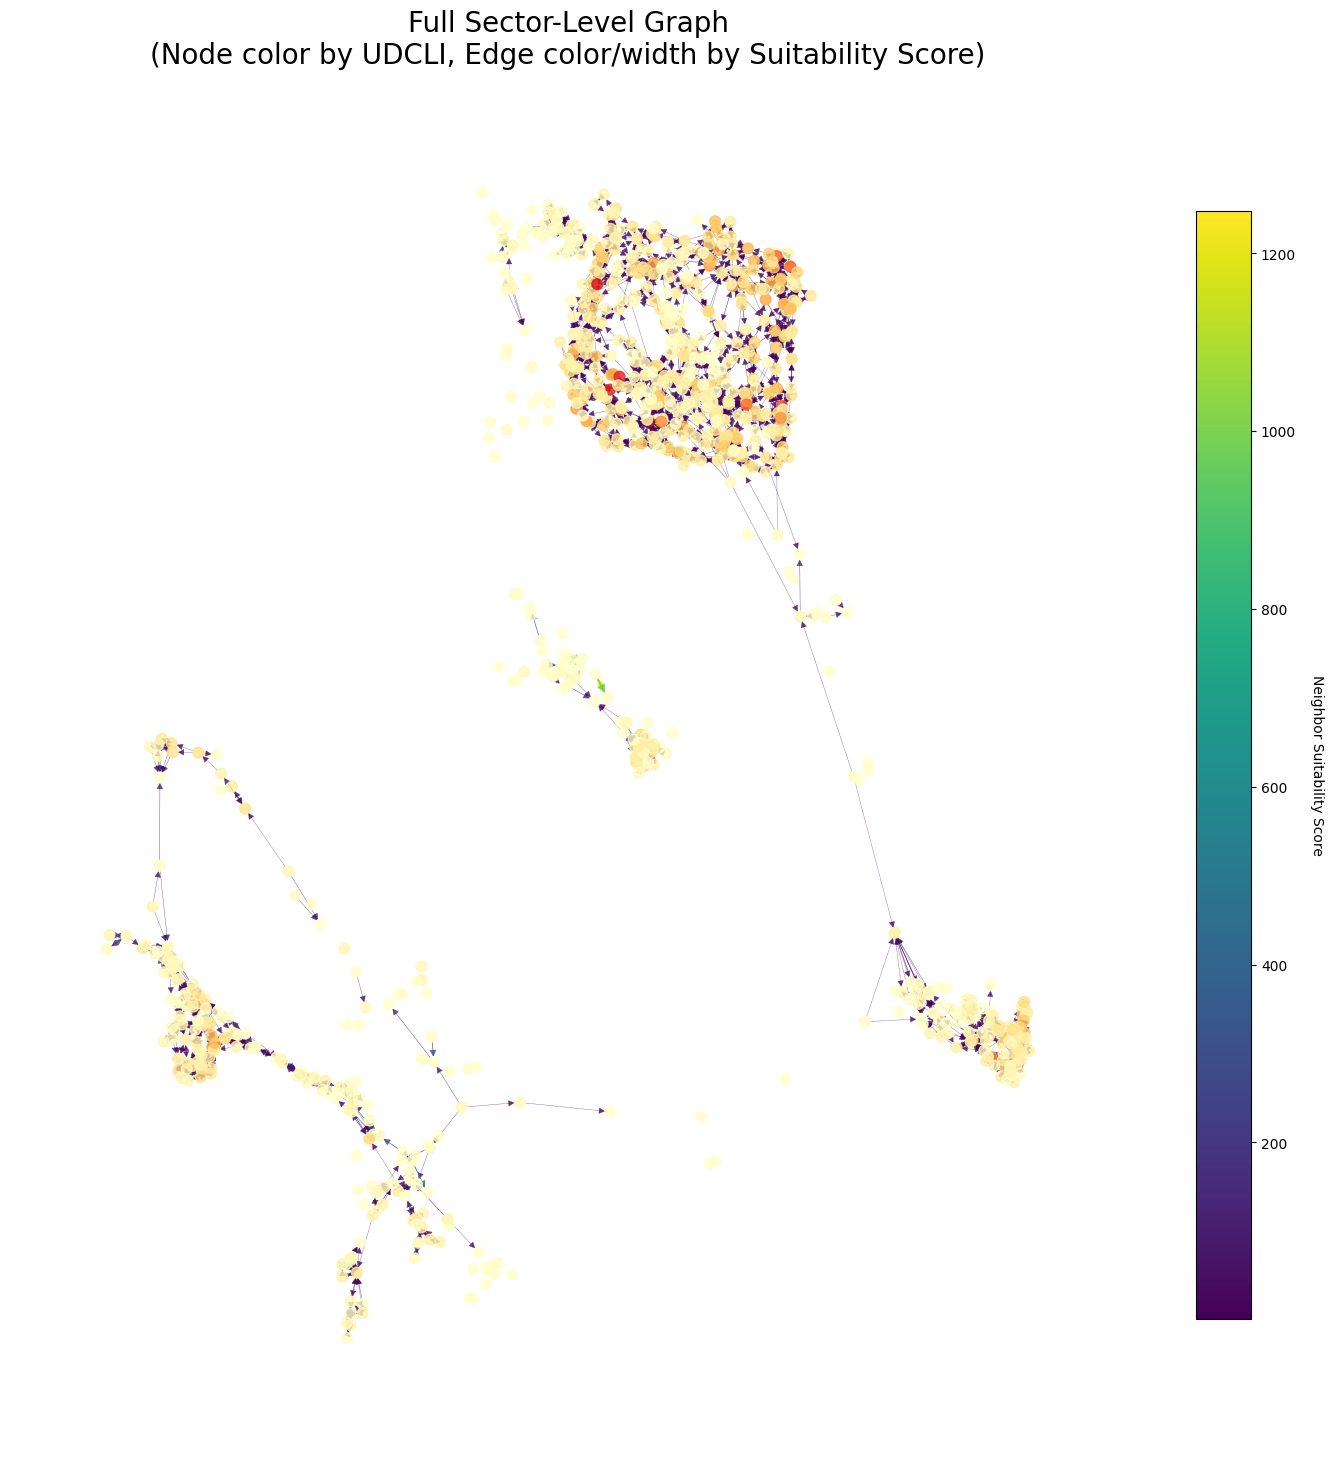


Visualizing the neighborhood for the specified sector: LT5927XA


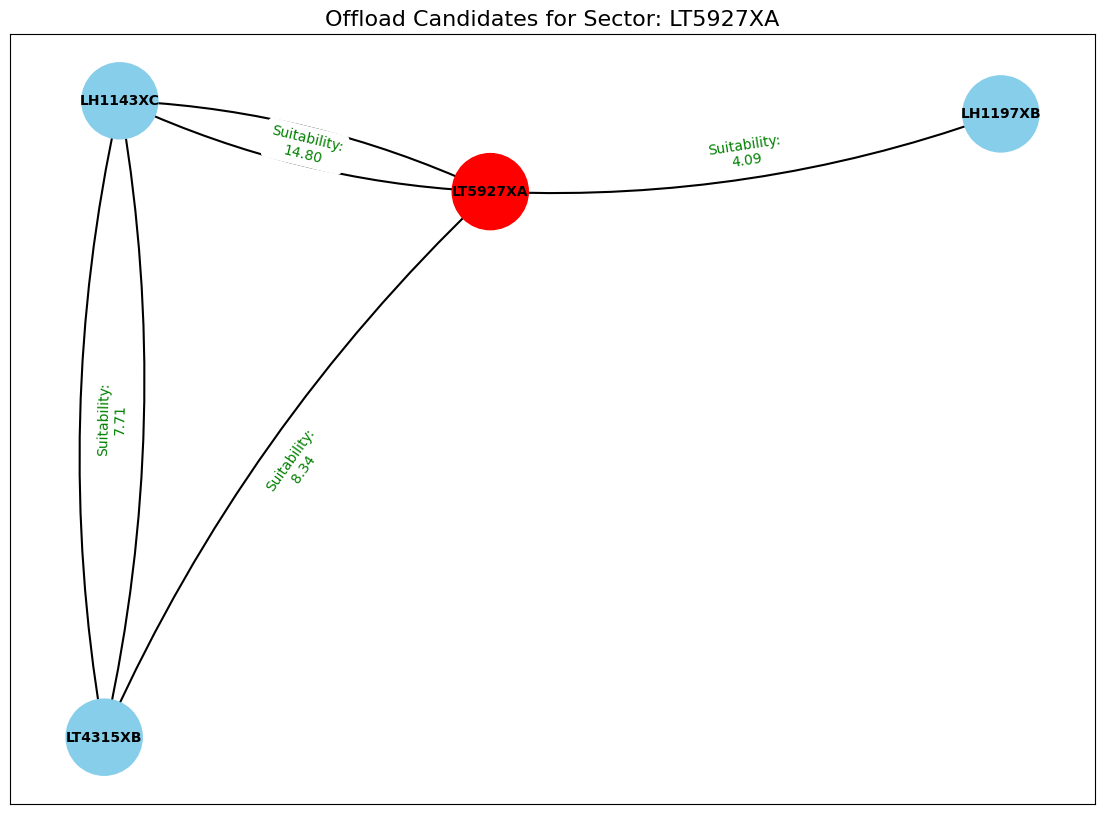

In [24]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import re

# --- 1. Define File Paths and Load Graph Components ---
data_dir = '../Data'
output_version = "V1.3"

sector_nodes_path = os.path.join(data_dir, f"graph_sector_node_features_{output_version}.csv")
sector_edges_path = os.path.join(data_dir, f"graph_sector_edge_list_{output_version}.csv")

try:
    print("--- Loading V1.3 Graph Components ---")
    df_sector_nodes = pd.read_csv(sector_nodes_path)
    df_sector_edges = pd.read_csv(sector_edges_path)
    print("Graph component files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required V1.3 graph component file was not found. Please ensure the previous step ran successfully. Details: {e}")
    exit()

# --- 2. Prepare Data for Visualization ---
# Using edge_attr=True is more robust, it loads all available columns as attributes
G_sector = nx.from_pandas_edgelist(
    df_sector_edges,
    source='source',
    target='target',
    edge_attr=True, 
    create_using=nx.DiGraph()
)
print(f"\nSector-level graph created with {G_sector.number_of_nodes()} nodes and {G_sector.number_of_edges()} edges.")

# --- 3. Visualization of the Whole Sector Graph (Revised to fix error) ---
print("\nVisualizing the whole sector graph (Edges colored by Suitability Score)...")

# --- MODIFICATION: Create Figure and Axes objects explicitly ---
fig, ax = plt.subplots(figsize=(18, 18))

# Prepare edge colors based on 'feat_suitability'
edge_suitability_scores = list(nx.get_edge_attributes(G_sector, 'feat_suitability').values())

if edge_suitability_scores:
    norm = mcolors.Normalize(vmin=min(edge_suitability_scores), vmax=max(edge_suitability_scores))
    cmap = cm.viridis
    edge_colors = [cmap(norm(score)) for score in nx.get_edge_attributes(G_sector, 'feat_suitability').values()]
    edge_widths = [0.2 + norm(score) * 1.5 for score in nx.get_edge_attributes(G_sector, 'feat_suitability').values()]
else:
    edge_colors = 'grey'
    edge_widths = 0.5
    print("Warning: 'feat_suitability' not found as an edge attribute. Using default edge colors.")

# Prepare node colors based on UDCLI
node_colors = []
udcli_map = df_sector_nodes.set_index('Canonical_Sector_ID')['UDCLI'].to_dict()
for node in G_sector.nodes():
    node_colors.append(udcli_map.get(node, 0))

pos = nx.spring_layout(G_sector, k=0.7, iterations=50, seed=42)

# --- MODIFICATION: Pass the 'ax' object to the draw function ---
nx.draw(G_sector, pos, ax=ax, node_color=node_colors, cmap=plt.cm.YlOrRd, 
        with_labels=False, node_size=60, width=edge_widths, 
        edge_color=edge_colors, alpha=0.8)

# --- MODIFICATION: Set title on the axes and create colorbar from the figure ---
ax.set_title("Full Sector-Level Graph\n(Node color by UDCLI, Edge color/width by Suitability Score)", fontsize=20)
if edge_suitability_scores:
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8) # Pass ax here
    cbar.set_label('Neighbor Suitability Score', rotation=270, labelpad=20)

plt.show()


# --- 4. Visualization of a Specific Node and its Neighborhood (Revised to fix error) ---
user_specified_node = 'LT5927XA'
print(f"\nVisualizing the neighborhood for the specified sector: {user_specified_node}")

def standardize_sector_id_single(sid):
    if pd.isna(sid) or str(sid).lower() == 'nan': return np.nan
    sid_str = str(sid).strip().upper()
    if re.match(r"^[HLT][A-Z0-9]{3,}[A-Z]$", sid_str):
        if sid_str.startswith('H') and not sid_str.startswith('LH'): return 'L' + sid_str
        if sid_str.startswith('T') and not sid_str.startswith('LT'): return 'L' + sid_str
        return sid_str
    return sid_str

sample_node_id = standardize_sector_id_single(user_specified_node)

if sample_node_id in G_sector:
    successors = list(G_sector.successors(sample_node_id))
    neighborhood_nodes = [sample_node_id] + successors
    G_sample = G_sector.subgraph(neighborhood_nodes)

    # --- MODIFICATION: Create Figure and Axes objects explicitly ---
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_title(f"Offload Candidates for Sector: {sample_node_id}", fontsize=16)
    
    sample_pos = nx.spring_layout(G_sample, seed=42, k=1.5)
    
    node_color_map = ['red' if node == sample_node_id else 'skyblue' for node in G_sample.nodes()]

    # --- MODIFICATION: Pass 'ax' to all drawing functions ---
    nx.draw_networkx_nodes(G_sample, sample_pos, ax=ax, node_size=3000, node_color=node_color_map)
    nx.draw_networkx_edges(G_sample, sample_pos, ax=ax, arrowstyle='->', arrowsize=25, connectionstyle='arc3,rad=0.1', width=1.5)
    nx.draw_networkx_labels(G_sample, sample_pos, ax=ax, font_size=10, font_weight='bold')
    
    edge_labels = nx.get_edge_attributes(G_sample, 'feat_suitability')
    if edge_labels:
        for key, val in edge_labels.items():
            edge_labels[key] = f"Suitability:\n{val:.2f}" if pd.notna(val) else "N/A"
        nx.draw_networkx_edge_labels(G_sample, sample_pos, ax=ax, edge_labels=edge_labels, font_color='green')
    
    plt.show()
else:
    print(f"ERROR: The specified node '{sample_node_id}' was not found in the graph.")
    print("Example nodes available in the graph:", list(G_sector.nodes())[:5])

In [30]:
import pandas as pd
import numpy as np
import os
import re

# --- 1. Configuration and File Paths ---
data_dir = '../Data'
output_version = "V1.3"

intra_freq_file = os.path.join(data_dir, 'EutranIntraFreqNCell-ardebil-final.csv')
inter_freq_file = os.path.join(data_dir, 'EUTRANINTERFREQNCELL.csv')


# --- 2. Helper Functions ---
def standardize_cell_id(cell_id_series):
    """Takes a series of cell names and returns them in a standardized string format."""
    if not isinstance(cell_id_series, pd.Series):
        cell_id_series = pd.Series(cell_id_series)
    
    clean_ids = []
    for cid in cell_id_series:
        if pd.isna(cid):
            clean_ids.append(np.nan)
            continue
        clean_ids.append(str(cid).strip().upper())
    return pd.Series(clean_ids, index=cell_id_series.index)

def clean_and_convert_to_numeric(series):
    """
    Cleans a series containing strings like '3dB', 'CIO_N3DB' etc.,
    extracts the numeric part, and converts to a numeric type.
    """
    # Convert all values to string to handle mixed types
    s = series.astype(str)
    # Use regex to find the first sequence of digits, optionally preceded by a minus sign
    s = s.str.extract(r'(-?\d+\.?\d*)', expand=False)
    # Convert the extracted strings to numeric, coercing errors to NaN
    return pd.to_numeric(s, errors='coerce')


# --- 3. Main Processing Script ---
try:
    print("--- Loading Cell Relationship Files ---")
    df_intra = pd.read_csv(intra_freq_file, low_memory=False)
    df_inter = pd.read_csv(inter_freq_file, low_memory=False)
    print("Files loaded successfully.")

    # Standardize column names to lowercase
    df_intra.columns = [col.strip().lower() for col in df_intra.columns]
    df_inter.columns = [col.strip().lower() for col in df_inter.columns]

    cell_edge_lists = []

    # --- Process Intra-Frequency Edges ---
    print("\n--- Processing Intra-Frequency Edges ---")
    intra_src_col, intra_tgt_col = 'cell name', 'neighbourcellname'
    intra_feat_cols = ['cellindividualoffset', 'cellqoffset']
    
    if all(col in df_intra.columns for col in [intra_src_col, intra_tgt_col] + intra_feat_cols):
        # --- FIX V1.3: Apply cleaning function BEFORE creating the edge dataframe ---
        print("Cleaning feature columns...")
        for col in intra_feat_cols:
            df_intra[col] = clean_and_convert_to_numeric(df_intra[col])

        df_intra['source'] = standardize_cell_id(df_intra[intra_src_col])
        df_intra['target'] = standardize_cell_id(df_intra[intra_tgt_col])
        df_intra_edges = df_intra[['source', 'target'] + intra_feat_cols].rename(columns={
            'cellindividualoffset': 'feat_offset',
            'cellqoffset': 'feat_qoffset'
        })
        df_intra_edges['edge_type'] = 'intra_freq'
        cell_edge_lists.append(df_intra_edges)
        print(f"Processed {len(df_intra_edges)} intra-frequency cell edges.")
    else:
        print(f"Warning: Could not process intra-frequency edges. Required columns not found.")


    # --- Process Inter-Frequency Edges ---
    print("\n--- Processing Inter-Frequency Edges ---")
    inter_src_col, inter_tgt_col = 'cell__name', 'localcellname'
    inter_feat_cols = ['cellindividualoffset', 'cellqoffset', 'nohoflag']
    
    if all(col in df_inter.columns for col in [inter_src_col, inter_tgt_col] + inter_feat_cols):
        # --- FIX V1.3: Apply cleaning function BEFORE creating the edge dataframe ---
        print("Cleaning feature columns...")
        for col in ['cellindividualoffset', 'cellqoffset']:
            df_inter[col] = clean_and_convert_to_numeric(df_inter[col])
            
        df_inter['source'] = standardize_cell_id(df_inter[inter_src_col])
        df_inter['target'] = standardize_cell_id(df_inter[inter_tgt_col])
        df_inter_edges = df_inter[['source', 'target'] + inter_feat_cols].rename(columns={
            'cellindividualoffset': 'feat_offset',
            'cellqoffset': 'feat_qoffset',
            'nohoflag': 'feat_no_ho'
        })
        df_inter_edges['edge_type'] = 'inter_freq'
        cell_edge_lists.append(df_inter_edges)
        print(f"Processed {len(df_inter_edges)} inter-frequency cell edges.")
    else:
        print(f"Warning: Could not process inter-frequency edges. Required columns not found.")

    # --- Combine and Save Final Edge List ---
    if cell_edge_lists:
        df_cell_edges_final = pd.concat(cell_edge_lists, ignore_index=True)
        df_cell_edges_final.dropna(subset=['source', 'target'], inplace=True)
        
        output_filename = os.path.join(data_dir, f"graph_cell_edge_list_{output_version}.csv")
        df_cell_edges_final.to_csv(output_filename, index=False)
        
        print("\n--- Final Cell Edge List (V1.3) ---")
        print(df_cell_edges_final.head())
        print("\nInfo (check non-null counts for feat_offset and feat_qoffset):")
        df_cell_edges_final.info()
        print(f"\nSuccessfully saved the final cell edge list to: {output_filename}")
    else:
        print("\nNo edge data could be processed. No output file was generated.")

except FileNotFoundError as e:
    print(f"ERROR: An input file was not found. Please check your '/Data' directory. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Loading Cell Relationship Files ---
Files loaded successfully.

--- Processing Intra-Frequency Edges ---
Cleaning feature columns...
Processed 104536 intra-frequency cell edges.

--- Processing Inter-Frequency Edges ---
Cleaning feature columns...
Processed 204236 inter-frequency cell edges.

--- Final Cell Edge List (V1.3) ---
      source     target  feat_offset  feat_qoffset   edge_type feat_no_ho
0  LH1000XD1  LH1506XA1            0             0  intra_freq        NaN
1  LH1000XB5  LT4299XE5            0             0  intra_freq        NaN
2  LH1000XB2  LT4299XB2            0             0  intra_freq        NaN
3  LH1000XD3  LT4319XC3            0             0  intra_freq        NaN
4  LH1000XD2  LH1008XC2            0             0  intra_freq        NaN

Info (check non-null counts for feat_offset and feat_qoffset):
<class 'pandas.core.frame.DataFrame'>
Index: 308770 entries, 0 to 308771
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  -----

--- Loading V1.3 Graph Components ---
Graph component files loaded successfully.

Finding cells for target sector: LT5927XA
Found 6 cells in sector LT5927XA: ['LT5927XA1', 'LT5927XA2', 'LT5927XA3', 'LT5927XA5', 'LT5927XA7', 'LT5927XA8']
Created subgraph with 261 nodes and 8268 edges.

--- Generating Cell-Level Visualization ---


d:\pyproject\github\ML_based-Pro-LTE-Opt\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


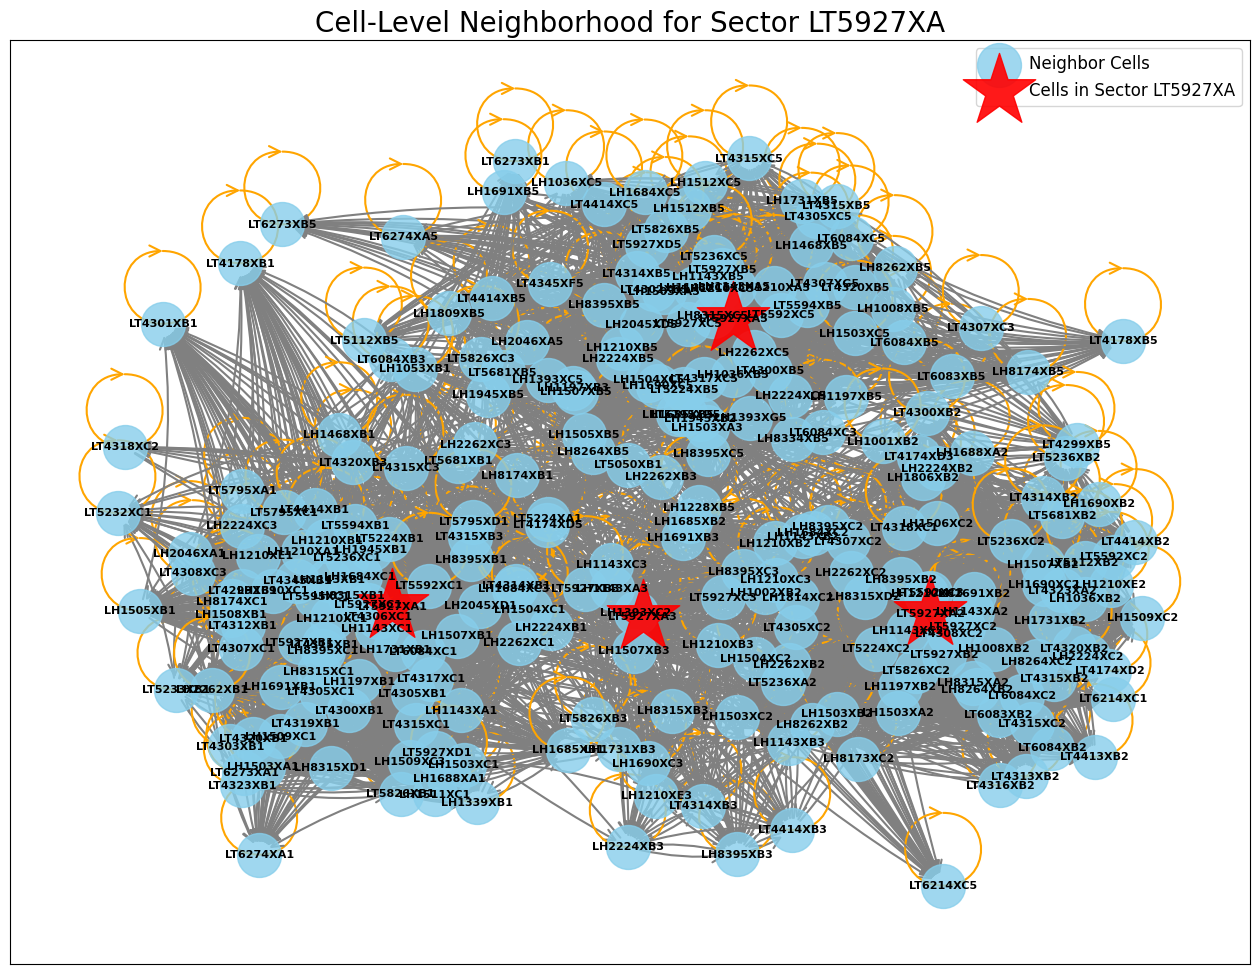

In [31]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import re

# --- 1. Load the V1.3 Graph Component Files ---
data_dir = '../Data'
output_version = "V1.3"

try:
    print("--- Loading V1.3 Graph Components ---")
    df_cell_nodes = pd.read_csv(os.path.join(data_dir, f"graph_cell_node_features_{output_version}.csv"))
    df_cell_edges = pd.read_csv(os.path.join(data_dir, f"graph_cell_edge_list_{output_version}.csv"))
    df_hierarchy = pd.read_csv(os.path.join(data_dir, f"graph_hierarchy_map_{output_version}.csv"))
    print("Graph component files loaded successfully.")
except FileNotFoundError as e:
    print(f"ERROR: A required V1.3 graph component file was not found. Please ensure the previous step ran successfully. Details: {e}")
    exit()

# --- 2. Identify the Target Sector and its Cells ---
target_sector = 'LT5927XA'
print(f"\nFinding cells for target sector: {target_sector}")

# Find all cells belonging to the target sector from the hierarchy map
cells_in_sector = df_hierarchy[df_hierarchy['Canonical_Sector_ID'] == target_sector]['Canonical_Cell_ID'].tolist()

if not cells_in_sector:
    print(f"ERROR: No cells found for sector '{target_sector}'. Please check the 'graph_hierarchy_map_V1.3.csv' file or the sector name.")
    exit()

print(f"Found {len(cells_in_sector)} cells in sector {target_sector}: {cells_in_sector}")

# --- 3. Build and Filter the Cell-Level Graph ---
# Create the full cell graph from the edge list
G_cell = nx.from_pandas_edgelist(
    df_cell_edges,
    source='source',
    target='target',
    edge_attr=True,
    create_using=nx.DiGraph()
)

# Find all neighbors of the cells in our target sector
neighbors = []
for cell in cells_in_sector:
    if G_cell.has_node(cell):
        # Get successors (nodes the cell points to)
        neighbors.extend(list(G_cell.successors(cell)))
        # Optionally, get predecessors (nodes that point to the cell)
        # neighbors.extend(list(G_cell.predecessors(cell)))

# Create the set of all nodes for our visualization subgraph
nodes_for_subgraph = list(set(cells_in_sector + neighbors))

# Create the subgraph
G_sample = G_cell.subgraph(nodes_for_subgraph)
print(f"Created subgraph with {G_sample.number_of_nodes()} nodes and {G_sample.number_of_edges()} edges.")


# --- 4. Prepare Data for Visualization ---
# Get Reference Power for node coloring
power_col = 'Reference signal power(0.1dBm)'
node_colors = []
power_map = {}
if power_col in df_cell_nodes.columns:
    # Create a lookup dictionary from Cell ID to its power
    power_lookup = df_cell_nodes.set_index('Canonical_Cell_ID')[power_col].to_dict()
    # Map each node in our subgraph to its power value
    for node in G_sample.nodes():
        power_map[node] = power_lookup.get(node, np.nan) # Use NaN for nodes not in the feature table
else:
    print(f"Warning: Power column '{power_col}' not found. Nodes will not be colored by power.")

# Define node shapes: star for cells in the target sector, circle for neighbors
node_shapes = ['*' if node in cells_in_sector else 'o' for node in G_sample.nodes()]

# Define edge colors based on type
edge_color_map = {'intra_freq': 'gray', 'inter_freq': 'orange'}
edge_colors = [edge_color_map.get(G_sample.edges[u, v].get('edge_type', ''), 'black') for u, v in G_sample.edges()]


# --- 5. Generate the Plot ---
print("\n--- Generating Cell-Level Visualization ---")
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G_sample, k=0.8, iterations=50, seed=42)

# Draw the neighbor nodes (circles)
nx.draw_networkx_nodes(G_sample, pos,
                       nodelist=[node for node, shape in zip(G_sample.nodes(), node_shapes) if shape == 'o'],
                       node_shape='o', node_size=1000, node_color='skyblue', alpha=0.8, label='Neighbor Cells')

# Draw the main sector's cells (stars)
nx.draw_networkx_nodes(G_sample, pos,
                       nodelist=[node for node, shape in zip(G_sample.nodes(), node_shapes) if shape == '*'],
                       node_shape='*', node_size=3000, node_color='red', alpha=0.9, label=f'Cells in Sector {target_sector}')

# Draw edges
nx.draw_networkx_edges(G_sample, pos, edge_color=edge_colors, width=1.5,
                       arrowstyle='->', arrowsize=20, connectionstyle='arc3,rad=0.1')

# Draw labels
nx.draw_networkx_labels(G_sample, pos, font_size=8, font_weight='bold')

plt.title(f"Cell-Level Neighborhood for Sector {target_sector}", fontsize=20)
plt.legend(scatterpoints=1, fontsize=12)
plt.show()